# Pose Detection model using transfer learning

### All Installations

In [3]:
!pip install -q tensorflow tensorflow_hub opencv-python

### All Imports

In [6]:
import tensorflow as tf
import tensorflow_hub as hub
import cv2
import numpy as np
from matplotlib import pyplot as plt
import requests
from PIL import Image
import io
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import random

In [5]:
model_name = "movenet_singlepose_lightning"
module = hub.load("https://tfhub.dev/google/movenet/singlepose/lightning/4")
movenet = module.signatures['serving_default']

### Keypoint names and connections for visualization


In [ ]:
KEYPOINT_DICT = {
    'nose': 0, 'left_eye': 1, 'right_eye': 2, 'left_ear': 3, 'right_ear': 4,
    'left_shoulder': 5, 'right_shoulder': 6, 'left_elbow': 7, 'right_elbow': 8,
    'left_wrist': 9, 'right_wrist': 10, 'left_hip': 11, 'right_hip': 12,
    'left_knee': 13, 'right_knee': 14, 'left_ankle': 15, 'right_ankle': 16
}

KEYPOINT_EDGE_INDS_TO_COLOR = {
    (0, 1): 'm', (0, 2): 'c', (1, 3): 'm', (2, 4): 'c', (0, 5): 'm',
    (0, 6): 'c', (5, 7): 'm', (7, 9): 'm', (6, 8): 'c', (8, 10): 'c',
    (5, 6): 'y', (5, 11): 'm', (6, 12): 'c', (11, 12): 'y',
    (11, 13): 'm', (13, 15): 'm', (12, 14): 'c', (14, 16): 'c'
}

In [ ]:
def movenet_inference(input_image):
    """Runs detection on an input image."""
    # Resize and pad the image to keep aspect ratio and fit input size
    input_image = tf.expand_dims(input_image, axis=0)
    input_image = tf.image.resize_with_pad(input_image, 192, 192)

    # Cast to int32 to run inference
    input_image = tf.cast(input_image, dtype=tf.int32)

    # Run model inference
    outputs = movenet(input_image)
    # Extract the keypoints properly - shape should be (17, 3)
    keypoints = outputs['output_0'].numpy()[0, 0]  # Remove both batch dimensions
    return keypoints

In [ ]:
def draw_keypoints(frame, keypoints, confidence_threshold=0.3):
    """Draws keypoints on the frame."""
    frame_copy = frame.copy()
    y, x, _ = frame.shape

    # MoveNet returns keypoints in shape (17, 3) where each row is [y, x, confidence]
    for i in range(len(keypoints)):
        ky, kx, kp_conf = keypoints[i]
        if kp_conf > confidence_threshold:
            # Scale keypoints to image size
            px = int(kx * x)
            py = int(ky * y)
            cv2.circle(frame_copy, (px, py), 4, (0, 255, 0), -1)

    return frame_copy

In [ ]:
def draw_connections(frame, keypoints, edges, confidence_threshold=0.3):
    """Draws skeleton connections."""
    frame_copy = frame.copy()
    y, x, _ = frame.shape

    for edge, color in edges.items():
        p1, p2 = edge

        # Get keypoints
        y1, x1, c1 = keypoints[p1]
        y2, x2, c2 = keypoints[p2]

        if c1 > confidence_threshold and c2 > confidence_threshold:
            # Scale to image coordinates
            px1 = int(x1 * x)
            py1 = int(y1 * y)
            px2 = int(x2 * x)
            py2 = int(y2 * y)

            # Map matplotlib color codes to BGR values for OpenCV
            color_map = {'m': (255, 0, 255), 'c': (255, 255, 0), 'y': (0, 255, 255)}
            bgr_color = color_map.get(color, (0, 0, 255))

            cv2.line(frame_copy, (px1, py1), (px2, py2), bgr_color, 2)

    return frame_copy

### Download and load a sample image using requests and PIL (more reliable in Colab)


In [ ]:
url = "https://images.pexels.com/photos/1199590/pexels-photo-1199590.jpeg?auto=compress&cs=tinysrgb&w=400"
response = requests.get(url)
image_pil = Image.open(io.BytesIO(response.content))
image_rgb = np.array(image_pil)

print(f"Image loaded successfully! Shape: {image_rgb.shape}")

Image loaded successfully! Shape: (267, 400, 3)


### Transfer learning example - create a simple activity classifier


In [ ]:
def extract_features(keypoints):
    """Extract features from keypoints for classification."""
    # Simple features: relative positions of key joints
    features = []

    # Example features: hip-knee angle, shoulder-hip alignment, etc.
    left_hip = keypoints[11]
    right_hip = keypoints[12]
    left_knee = keypoints[13]
    right_knee = keypoints[14]
    left_shoulder = keypoints[5]
    right_shoulder = keypoints[6]

    # Average hip position
    hip_y = (left_hip[0] + right_hip[0]) / 2
    hip_x = (left_hip[1] + right_hip[1]) / 2

    # Average knee position
    knee_y = (left_knee[0] + right_knee[0]) / 2
    knee_x = (left_knee[1] + right_knee[1]) / 2

    # Average shoulder position
    shoulder_y = (left_shoulder[0] + right_shoulder[0]) / 2
    shoulder_x = (left_shoulder[1] + right_shoulder[1]) / 2

    # Features
    features.extend([
        knee_y - hip_y,  # Vertical distance between knee and hip
        shoulder_y - hip_y,  # Vertical distance between shoulder and hip
        abs(left_knee[1] - right_knee[1]),  # Horizontal distance between knees
        abs(left_shoulder[1] - right_shoulder[1])  # Horizontal distance between shoulders
    ])

    return np.array(features)

### Create a simple classifier (you would typically train this on more data)


### Extract features from the current image as an example


In [ ]:
current_features = extract_features(keypoints)
print(f"\nExtracted features: {current_features}")


Extracted features: [-0.04515636 -0.3389055   0.02972409  0.14441362]


In [ ]:
# Generate synthetic training data (just for demonstration)
training_data = []
labels = []

for i in range(50):
    # Simulate different poses with random variations
    synthetic_features = current_features + np.random.normal(0, 0.05, size=current_features.shape)

    # Assign labels based on feature patterns
    if synthetic_features[0] < -0.1:  # Knee well below hip
        label = 'sitting'
    elif abs(synthetic_features[2]) > 0.2:  # Knees far apart
        label = 'standing_wide'
    else:
        label = 'standing'

    training_data.append(synthetic_features)
    labels.append(label)

# Convert to numpy arrays
X_train = np.array(training_data)
y_train = np.array(labels)

# Create and train the classifier
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

classifier = RandomForestClassifier(n_estimators=100, random_state=42)
classifier.fit(X_train_scaled, y_train)

# Predict on the current image
current_features_scaled = scaler.transform([current_features])
prediction = classifier.predict(current_features_scaled)[0]
prediction_proba = classifier.predict_proba(current_features_scaled)[0]

print(f"\nPredicted pose: {prediction}")
print("Prediction probabilities:")
for i, class_label in enumerate(classifier.classes_):
    print(f"  {class_label}: {prediction_proba[i]:.2f}")



Predicted pose: standing
Prediction probabilities:
  sitting: 0.01
  standing: 0.99


# Crop Disease Detection using Transfer Learning - Fully Fixed Version

### All Installations

In [ ]:
!pip install -q tensorflow tensorflow-hub matplotlib Pillow opencv-python seaborn scikit-learn

### All Imports

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import requests
import os
from PIL import Image
import io
import cv2
from sklearn.metrics import confusion_matrix
import seaborn as sns

### Create a sample dataset structure


In [ ]:
def create_sample_dataset():
    """Create a sample dataset structure with synthetic leaf images."""
    classes = ['healthy', 'diseased']

    # Create directory structure
    for split in ['train', 'validation']:
        for class_name in classes:
            os.makedirs(f'./crop_data/{split}/{class_name}', exist_ok=True)

    # Generate synthetic images
    for class_name in classes:
        for split in ['train', 'validation']:
            base_path = f'./crop_data/{split}/{class_name}'
            num_images = 10 if split == 'train' else 5

            for i in range(num_images):
                # Create base leaf image
                img = np.ones((224, 224, 3), dtype=np.uint8) * 255

                # Draw leaf shape
                leaf_center = (112, 112)

                if class_name == 'healthy':
                    # Green healthy leaf
                    base_color = (34, 139, 34)  # Forest green
                    img[:, :] = (50, 150, 50)  # Light green background

                    # Draw main leaf
                    cv2.ellipse(img, leaf_center, (80, 40), 0, 0, 360, base_color, -1)

                    # Add veins
                    cv2.line(img, (32, 112), (192, 112), (25, 100, 25), 2)
                    for j in range(4):
                        y_offset = 30 - j * 15
                        cv2.line(img, (112, 112), (60, 112 + y_offset), (25, 100, 25), 1)
                        cv2.line(img, (112, 112), (164, 112 + y_offset), (25, 100, 25), 1)
                else:
                    # Diseased leaf
                    base_color = (34, 100, 34)  # Darker green
                    img[:, :] = (80, 120, 80)  # Grayish green background

                    # Draw main leaf
                    cv2.ellipse(img, leaf_center, (80, 40), 0, 0, 360, base_color, -1)

                    # Add disease spots
                    for _ in range(15):
                        spot_x = np.random.randint(40, 184)
                        spot_y = np.random.randint(72, 152)
                        spot_radius = np.random.randint(3, 12)
                        spot_color = (np.random.randint(100, 180),
                                    np.random.randint(60, 120),
                                    np.random.randint(0, 60))
                        cv2.circle(img, (spot_x, spot_y), spot_radius, spot_color, -1)

                    # Add edge browning
                    cv2.ellipse(img, leaf_center, (85, 45), 0, 0, 360, (101, 67, 33), 3)

                # Add noise for realism
                noise = np.random.normal(0, 10, img.shape)
                img = np.clip(img + noise, 0, 255).astype(np.uint8)

                # Save image
                img_path = os.path.join(base_path, f'{class_name}_{split}_{i}.jpg')
                Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)).save(img_path)

    print("Sample dataset created successfully!")

### Create the sample dataset


In [ ]:
create_sample_dataset()

Sample dataset created successfully!


### Set up data paths


In [ ]:
data_dir = './crop_data'

### Create data generators


In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)

val_datagen = ImageDataGenerator(rescale=1./255)

### Create generators


In [ ]:
train_generator = train_datagen.flow_from_directory(
    os.path.join(data_dir, 'train'),
    target_size=(224, 224),
    batch_size=8,
    class_mode='categorical'
)

validation_generator = val_datagen.flow_from_directory(
    os.path.join(data_dir, 'validation'),
    target_size=(224, 224),
    batch_size=8,
    class_mode='categorical'
)

Found 20 images belonging to 2 classes.
Found 10 images belonging to 2 classes.


### Display sample images


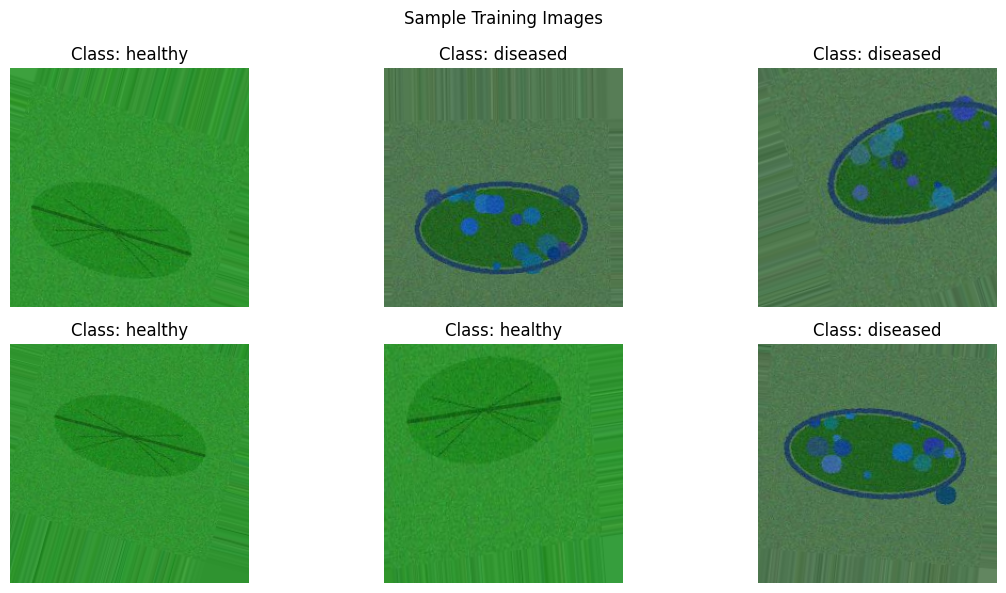

In [ ]:
plt.figure(figsize=(12, 6))
for i in range(6):
    plt.subplot(2, 3, i+1)
    img_batch, label_batch = next(train_generator)
    img = img_batch[0]
    label = label_batch[0]
    plt.imshow(img)
    plt.title(f'Class: {list(train_generator.class_indices.keys())[np.argmax(label)]}')
    plt.axis('off')
plt.suptitle('Sample Training Images')
plt.tight_layout()
plt.show()

### Build transfer learning model


In [ ]:
base_model = MobileNetV2(input_shape=(224, 224, 3),
                        include_top=False,
                        weights='imagenet')

### Freeze base model


In [ ]:
base_model.trainable = False

### Create model


In [ ]:
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(train_generator.num_classes, activation='softmax')
])

### Compile model


In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
print("Model Summary:")
model.summary()

Model Summary:


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,619,074 (9.99 MB)

 Trainable params: 361,090 (1.38 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

#### Phase 1: Feature extraction training


In [ ]:
print("\nPhase 1: Training with feature extraction...")
history = model.fit(
    train_generator,
    epochs=5,
    validation_data=validation_generator
)
print("\nAvailable metrics in history:")
print("History keys:", history.history.keys())


Phase 1: Training with feature extraction...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - accuracy: 0.7375 - loss: 0.4226 - val_accuracy: 1.0000 - val_loss: 0.0285
Epoch 2/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step - accuracy: 1.0000 - loss: 0.0594 - val_accuracy: 1.0000 - val_loss: 0.0025
Epoch 3/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 469ms/step - accuracy: 1.0000 - loss: 0.0025 - val_accuracy: 1.0000 - val_loss: 2.1635e-04
Epoch 4/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step - accuracy: 1.0000 - loss: 0.0070 - val_accuracy: 1.0000 - val_loss: 9.7384e-05
Epoch 5/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 586ms/step - accuracy: 1.0000 - loss: 5.9513e-04 - val_accuracy: 1.0000 - val_loss: 2.8131e-05

Available metrics in history:
History keys: dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


### Phase 2: Fine-tuning


In [ ]:
print("\nPhase 2: Fine-tuning the model...")
base_model.trainable = True
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Continue training
history_fine = model.fit(
    train_generator,
    epochs=3,
    initial_epoch=history.epoch[-1],
    validation_data=validation_generator
)

# Visualize combined training results
plt.figure(figsize=(12, 4))


Phase 2: Fine-tuning the model...


<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

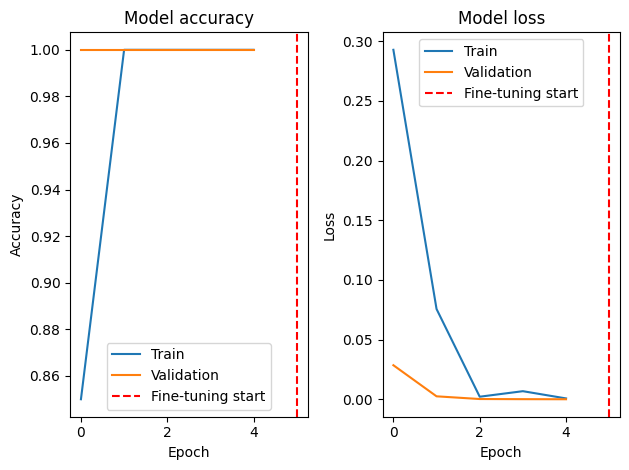

In [ ]:
acc_metric = 'accuracy' if 'accuracy' in history.history else 'acc'
val_acc_metric = 'val_accuracy' if 'val_accuracy' in history.history else 'val_acc'
try:
    acc = history.history[acc_metric] + history_fine.history[acc_metric]
    val_acc = history.history[val_acc_metric] + history_fine.history[val_acc_metric]
    loss = history.history['loss'] + history_fine.history['loss']
    val_loss = history.history['val_loss'] + history_fine.history['val_loss']
except KeyError as e:
    print(f"Warning: {e}")
    acc = history.history.get(acc_metric, [])
    val_acc = history.history.get(val_acc_metric, [])
    loss = history.history.get('loss', [])
    val_loss = history.history.get('val_loss', [])

plt.subplot(1, 2, 1)
plt.plot(acc)
plt.plot(val_acc)
plt.axvline(x=5, color='r', linestyle='--')  # Mark where fine-tuning starts
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation', 'Fine-tuning start'])

plt.subplot(1, 2, 2)
plt.plot(loss)
plt.plot(val_loss)
plt.axvline(x=5, color='r', linestyle='--')  # Mark where fine-tuning starts
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation', 'Fine-tuning start'])

plt.tight_layout()
plt.show()

### Disease classification function


In [ ]:
def predict_disease(img_path):
    """Predict crop disease from image."""
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    img_array = img_array / 255.0

    predictions = model.predict(img_array, verbose=0)
    class_names = list(train_generator.class_indices.keys())
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = np.max(predictions[0])

    return predicted_class, confidence

### Test predictions



--- Testing Predictions ---


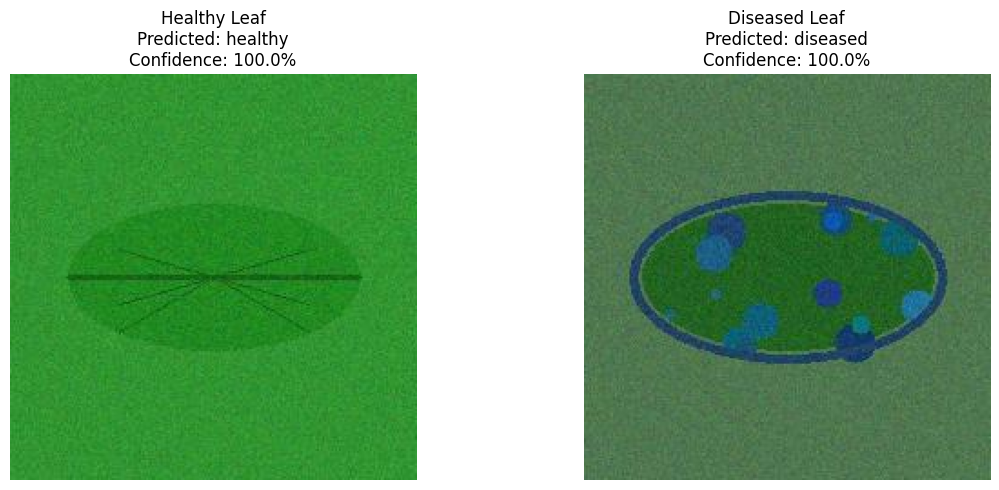

In [ ]:
print("\n--- Testing Predictions ---")

healthy_sample = os.path.join(data_dir, 'validation/healthy', 'healthy_validation_0.jpg')
diseased_sample = os.path.join(data_dir, 'validation/diseased', 'diseased_validation_0.jpg')

plt.figure(figsize=(12, 5))

test_images = [healthy_sample, diseased_sample]
titles = ['Healthy Leaf', 'Diseased Leaf']

for i, (img_path, title) in enumerate(zip(test_images, titles)):
    plt.subplot(1, 2, i+1)
    img = Image.open(img_path)
    plt.imshow(img)
    plt.axis('off')

    pred_class, conf = predict_disease(img_path)
    plt.title(f"{title}\nPredicted: {pred_class}\nConfidence: {conf:.1%}")

plt.tight_layout()
plt.show()

### Save model


In [ ]:
model.save('crop_disease_detection_model.h5')
print("\nModel saved successfully!")


Model saved successfully!


### Create confusion matrix



--- Creating Confusion Matrix ---


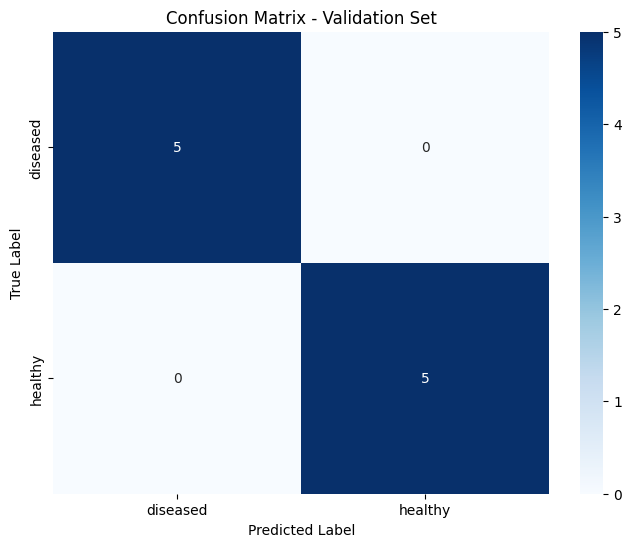

In [ ]:
print("\n--- Creating Confusion Matrix ---")

val_predictions = []
val_labels = []
validation_generator.reset()
for _ in range(len(validation_generator)):
    img_batch, label_batch = next(validation_generator)
    predictions = model.predict(img_batch, verbose=0)
    val_predictions.extend(np.argmax(predictions, axis=1))
    val_labels.extend(np.argmax(label_batch, axis=1))
cm = confusion_matrix(val_labels, val_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=train_generator.class_indices.keys(),
            yticklabels=train_generator.class_indices.keys())
plt.title('Confusion Matrix - Validation Set')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

### Final summary


In [ ]:
print("\nCrop Disease Detection Summary:")
print("--------------------------------")
print(f"Training samples: {train_generator.n}")
print(f"Validation samples: {validation_generator.n}")
print(f"Number of classes: {train_generator.num_classes}")
print(f"Classes: {list(train_generator.class_indices.keys())}")
print(f"Final training accuracy: {acc[-1]:.2%}" if acc else "N/A")
print(f"Final validation accuracy: {val_acc[-1]:.2%}" if val_acc else "N/A")


Crop Disease Detection Summary:
--------------------------------
Training samples: 20
Validation samples: 10
Number of classes: 2
Classes: ['diseased', 'healthy']
Final training accuracy: 100.00%
Final validation accuracy: 100.00%


# Transfer learn video classification model with movienet

### All Installations

In [ ]:
!pip install -q tensorflow tensorflow_hub opencv-python

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import cv2
import numpy as np
from matplotlib import pyplot as plt
import os
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import TimeDistributed, LSTM, Dense, Dropout, GlobalAveragePooling2D

### Function to extract frames from video


In [ ]:
def extract_frames(video_path, num_frames=64):
    """Extract frames from video for classification."""
    cap = cv2.VideoCapture(video_path)
    frames = []
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if total_frames == 0:
        print(f"Error: Could not read frames from {video_path}")
        return None
    indices = np.linspace(0, max(0, total_frames - 1), num_frames).astype(int)

    for idx in indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        if ret:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = cv2.resize(frame, (224, 224))
            frames.append(frame)

    cap.release()
    while len(frames) < num_frames:
        frames.append(frames[-1] if frames else np.zeros((224, 224, 3), dtype=np.uint8))
    return np.array(frames)

### Download a sample video


In [ ]:
!wget -q -O sample_video.mp4 "https://test-videos.co.uk/vids/bigbuckbunny/mp4/h264/360/Big_Buck_Bunny_360_10s_1MB.mp4"

### Alternative: Create a simple test video


In [ ]:
def create_test_video():
    """Create a simple test video."""
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter('test_video.mp4', fourcc, 30.0, (224, 224))

    for i in range(90):
        frame = np.zeros((224, 224, 3), dtype=np.uint8)
        x = int(112 + 80 * np.sin(i * 0.1))
        y = int(112 + 80 * np.cos(i * 0.1))
        cv2.circle(frame, (x, y), 20, (255, 255, 255), -1)
        cv2.line(frame, (112, 112), (x, y), (128, 128, 128), 2)
        out.write(frame)

    out.release()
    return 'test_video.mp4'

### Load Kinetics-400 labels


In [ ]:
KINETICS_URL = "https://raw.githubusercontent.com/deepmind/kinetics-i3d/master/data/label_map.txt"
try:
    labels_path = tf.keras.utils.get_file("labels.txt", KINETICS_URL)
    with open(labels_path) as f:
        labels = [line.strip() for line in f.readlines()]
    print(f"Loaded {len(labels)} action labels")
except Exception as e:
    print(f"Error loading labels: {e}")
    labels = [f"Action_{i}" for i in range(400)]  # Fallback labels

Loaded 400 action labels


In [ ]:
print("\n--- Using I3D Model ---")
try:
    # Load the I3D model
    i3d = hub.load("https://tfhub.dev/deepmind/i3d-kinetics-400/1")

    # Get the default signature
    i3d_model = i3d.signatures['default']

    # Preprocess frames for I3D
    # I3D expects float32 values in range [-1, 1]
    preprocessed_frames = frames.astype(np.float32) / 127.5 - 1.0

    # Add batch dimension
    video_batch = np.expand_dims(preprocessed_frames, 0)

    # Convert to tf.constant with correct dtype
    video_tensor = tf.constant(video_batch, dtype=tf.float32)

    # Make prediction
    # I3D expects input shape: [batch_size, num_frames, height, width, 3]
    outputs = i3d_model(video_tensor)
    predictions = outputs['default'].numpy()[0]

    # Get top 5 predictions
    top_5_indices = np.argsort(predictions)[-5:][::-1]

    print("\nTop 5 predicted actions:")
    for idx in top_5_indices:
        print(f"{labels[idx]}: {predictions[idx]:.3f}")

except Exception as e:
    print(f"Error with I3D model: {e}")
    print("Falling back to alternative approach...")

# Alternative: Use MobileNetV2 for video classification
print("\n--- Alternative: Video Classification with MobileNetV2 ---")


--- Using I3D Model ---

Top 5 predicted actions:
scuba diving: 9.202
singing: 8.158
playing harp: 6.590
playing didgeridoo: 6.353
taking a shower: 5.917

--- Alternative: Video Classification with MobileNetV2 ---


In [ ]:
def create_video_classifier(num_classes=10):
    """Create a video classifier using MobileNetV2 and LSTM."""
    # Base model for feature extraction
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False

    # Model architecture
    inputs = tf.keras.Input(shape=(None, 224, 224, 3))

    # TimeDistributed wrapper applies the base_model to each frame
    x = TimeDistributed(base_model)(inputs)
    x = TimeDistributed(GlobalAveragePooling2D())(x)

    # LSTM for temporal processing
    x = LSTM(256)(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
# Create the model
model = create_video_classifier(10)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

print("\nCustom video classifier model created!")
model.summary()


Custom video classifier model created!


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, None, 224, 224, │             0 │
│                                 │ 3)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_8              │ (None, None, 7, 7,     │     2,257,984 │
│ (TimeDistributed)               │ 1280)                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_9              │ (None, None, 1280)     │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 256)            │     1,573,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,866,058 (14.75 MB)

 Trainable params: 1,608,074 (6.13 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
# Simple CNN+LSTM model for video classification
print("\n--- Simple CNN+LSTM Model ---")

def create_simple_video_model(num_classes=10):
    """Create a simpler video classification model."""
    inputs = tf.keras.Input(shape=(None, 224, 224, 3))

    # Simple CNN feature extractor
    x = TimeDistributed(tf.keras.layers.Conv2D(32, 3, activation='relu'))(inputs)
    x = TimeDistributed(tf.keras.layers.MaxPooling2D())(x)
    x = TimeDistributed(tf.keras.layers.Conv2D(64, 3, activation='relu'))(x)
    x = TimeDistributed(tf.keras.layers.MaxPooling2D())(x)
    x = TimeDistributed(tf.keras.layers.Conv2D(128, 3, activation='relu'))(x)
    x = TimeDistributed(tf.keras.layers.GlobalAveragePooling2D())(x)

    # LSTM for temporal modeling
    x = LSTM(64)(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

simple_model = create_simple_video_model(10)
simple_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


--- Simple CNN+LSTM Model ---


In [ ]:
print("Simple video classifier created!")

# Create synthetic training data
def create_synthetic_video_data(num_videos=20, num_frames=16, num_classes=10):
    """Create synthetic video data for demonstration."""
    X = []
    y = []

    for _ in range(num_videos):
        # Create random video frames
        video = np.random.rand(num_frames, 224, 224, 3).astype(np.float32)
        X.append(video)

        # Random one-hot label
        label = np.zeros(num_classes)
        label[np.random.randint(0, num_classes)] = 1
        y.append(label)

    return np.array(X), np.array(y)

# Generate synthetic data
X_train, y_train = create_synthetic_video_data()
print(f"\nSynthetic data shape: {X_train.shape}")

# Train the simple model (1 epoch for demo)
print("\nTraining simple model...")
history = simple_model.fit(X_train, y_train, batch_size=2, epochs=1, verbose=1)

# Test on real video
if frames is not None:
    # Prepare video for prediction
    test_frames = frames[:16].astype(np.float32) / 255.0  # Normalize
    test_video = np.expand_dims(test_frames, 0)

    # Make prediction
    predictions = simple_model.predict(test_video)
    predicted_class = np.argmax(predictions[0])
    confidence = predictions[0][predicted_class]

    print(f"\nSimple model prediction: Class {predicted_class} (confidence: {confidence:.2%})")

Simple video classifier created!

Synthetic data shape: (20, 16, 224, 224, 3)

Training simple model...
10/10 ━━━━━━━━━━━━━━━━━━━━ 92s 8s/step - accuracy: 0.2795 - loss: 2.2691
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step

Simple model prediction: Class 0 (confidence: 14.46%)


### Demonstrate video augmentation


In [ ]:
def augment_video(frames):
    """Apply augmentation to video frames."""
    augmented = []

    for frame in frames:
        # Random brightness
        frame = tf.image.random_brightness(frame, 0.2)
        # Random contrast
        frame = tf.image.random_contrast(frame, 0.8, 1.2)
        # Random flip with 50% probability
        if np.random.random() > 0.5:
            frame = tf.image.flip_left_right(frame)
        augmented.append(frame)

    return tf.stack(augmented)

### Show augmented frames


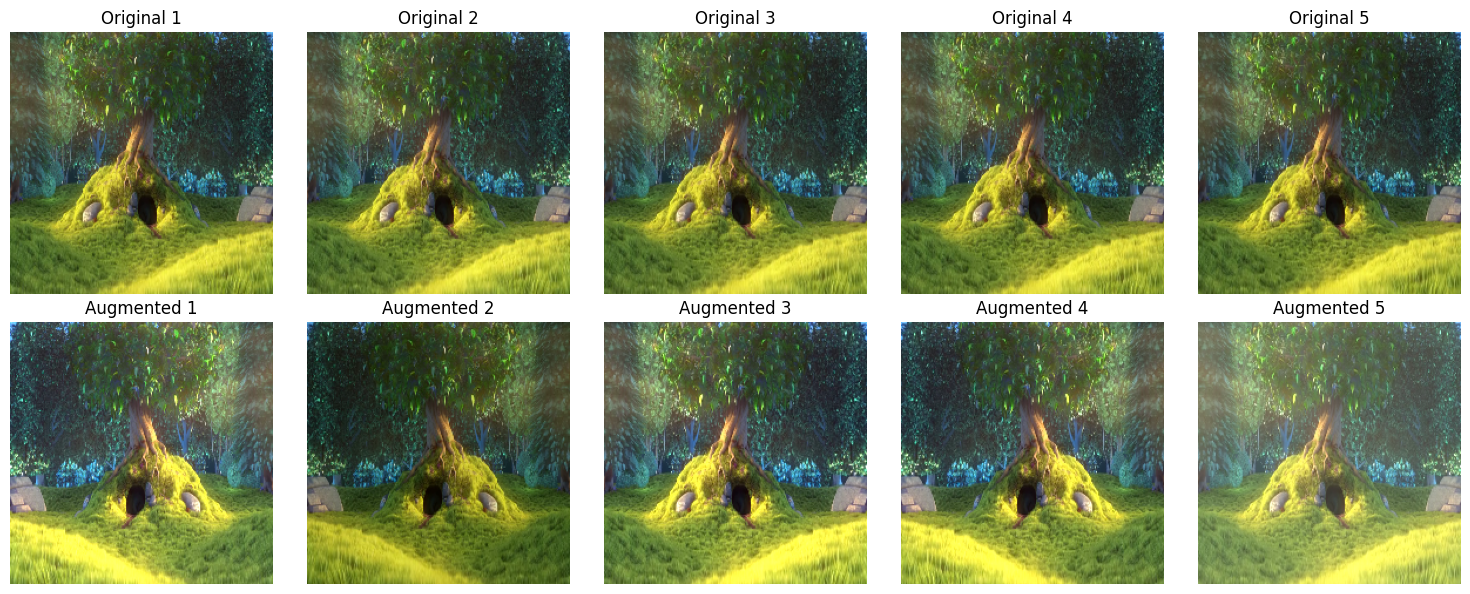

In [ ]:
if frames is not None:
    augmented = augment_video(frames[:5].astype(np.float32) / 255.0)

    plt.figure(figsize=(15, 6))
    for i in range(5):
        plt.subplot(2, 5, i+1)
        plt.imshow(frames[i])
        plt.title(f'Original {i+1}')
        plt.axis('off')

        plt.subplot(2, 5, i+6)
        plt.imshow(augmented[i])
        plt.title(f'Augmented {i+1}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Transfer learn sound classification with yamnet

### All Installations

In [7]:
!pip install -q tensorflow tensorflow_hub librosa soundfile
!pip install -q pydub

### All Imports

In [8]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import matplotlib.pyplot as plt
import librosa
import soundfile as sf
import pandas as pd
import os
from pydub.generators import Sine

### Load YAMNet model


In [9]:
print("Loading YAMNet model...")
yamnet_model = hub.load('https://tfhub.dev/google/yamnet/1')

Loading YAMNet model...


### Load class names


In [10]:
class_map_path = yamnet_model.class_map_path().numpy().decode('utf-8')
class_names = list(pd.read_csv(class_map_path)['display_name'])
print(f"Loaded {len(class_names)} class names")

Loaded 521 class names


### Function to load and preprocess audio


In [ ]:
def load_audio_file(file_path):
    """Load audio file and convert to YAMNet format."""
    try:
        # Read the audio file
        audio, sample_rate = sf.read(file_path, dtype='float32')

        # Convert to mono if stereo
        if len(audio.shape) > 1:
            audio = np.mean(audio, axis=1)

        # Resample to 16kHz if necessary
        if sample_rate != 16000:
            audio = librosa.resample(audio, orig_sr=sample_rate, target_sr=16000)

        return audio
    except Exception as e:
        print(f"Error loading audio file: {e}")
        return None

### Function to classify audio


In [11]:
def classify_audio(audio):
    """Classify audio using YAMNet."""
    if audio is None:
        return None, None, None

    # Get embeddings and predictions - YAMNet returns 3 values
    scores, embeddings, spectrogram = yamnet_model(audio)

    return scores.numpy(), embeddings.numpy(), spectrogram.numpy()

### Create and save a test audio file


In [ ]:
print("\nGenerating test audio...")
tone = Sine(440).to_audio_segment(duration=1000)  # 440 Hz for 1 second
tone.export("test_tone.wav", format="wav")


Generating test audio...


<_io.BufferedRandom name='test_tone.wav'>

In [ ]:
# Generate synthetic environmental sound
sample_rate = 16000
duration = 3  # seconds
t = np.linspace(0, duration, sample_rate * duration)

In [ ]:
# White noise for rain
rain = np.random.normal(0, 0.1, len(t))
# Add some low-frequency components
rain += 0.05 * np.sin(2 * np.pi * 100 * t)

In [ ]:
# Save the synthetic rain sound
sf.write('synthetic_rain.wav', rain.astype(np.float32), sample_rate)

In [ ]:
# Classify the test audio
print("\nClassifying test tone...")
test_audio = load_audio_file('test_tone.wav')


Classifying test tone...


Number of time windows: 2
Number of classes: 521

Top 5 predictions (averaged across time):
Telephone: 0.989
Busy signal: 0.981
Alarm: 0.911
Dial tone: 0.858
Sine wave: 0.076

Predictions for each time window:
Window 0: Telephone (0.995)
Window 1: Telephone (0.983)


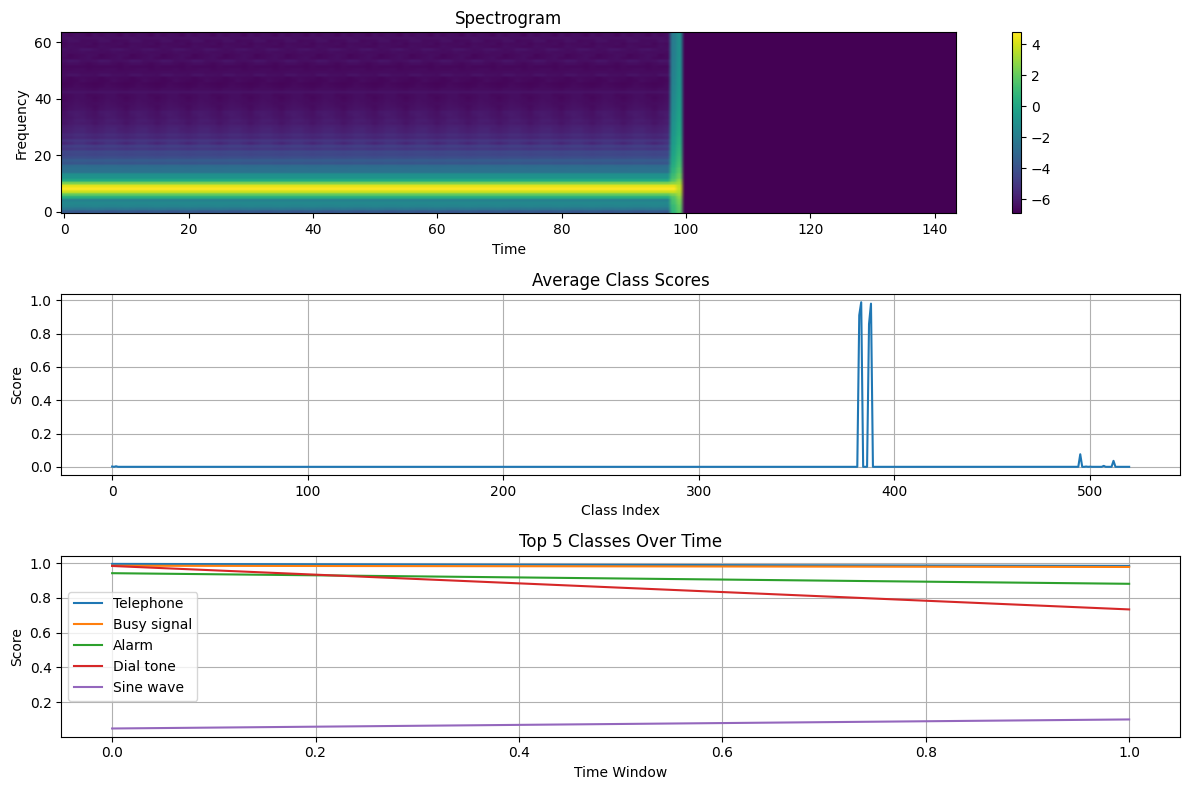

In [ ]:
if test_audio is not None:
    scores, embeddings, spectrogram = classify_audio(test_audio)

    if scores is not None:
        # Display results
        print(f"Number of time windows: {scores.shape[0]}")
        print(f"Number of classes: {scores.shape[1]}")

        # Get average scores across all time windows
        avg_scores = np.mean(scores, axis=0)
        top_5_indices = np.argsort(avg_scores)[-5:][::-1]

        print("\nTop 5 predictions (averaged across time):")
        for idx in top_5_indices:
            print(f"{class_names[idx]}: {avg_scores[idx]:.3f}")

        # Show predictions for each time window
        print("\nPredictions for each time window:")
        for i in range(min(3, scores.shape[0])):  # Show first 3 windows
            top_class_idx = np.argmax(scores[i])
            print(f"Window {i}: {class_names[top_class_idx]} ({scores[i][top_class_idx]:.3f})")

        # Visualize spectrogram and scores
        plt.figure(figsize=(12, 8))

        plt.subplot(3, 1, 1)
        plt.imshow(spectrogram.T, aspect='auto', origin='lower')
        plt.title('Spectrogram')
        plt.xlabel('Time')
        plt.ylabel('Frequency')
        plt.colorbar()

        plt.subplot(3, 1, 2)
        plt.plot(avg_scores)
        plt.title('Average Class Scores')
        plt.xlabel('Class Index')
        plt.ylabel('Score')
        plt.grid(True)

        plt.subplot(3, 1, 3)
        # Show scores for top 5 classes over time
        for idx in top_5_indices:
            plt.plot(scores[:, idx], label=class_names[idx])
        plt.title('Top 5 Classes Over Time')
        plt.xlabel('Time Window')
        plt.ylabel('Score')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()

In [ ]:
# Classify the synthetic rain sound
print("\nClassifying synthetic rain...")
rain_audio = load_audio_file('synthetic_rain.wav')

if rain_audio is not None:
    scores, embeddings, spectrogram = classify_audio(rain_audio)

    if scores is not None:
        avg_scores = np.mean(scores, axis=0)
        top_5_indices = np.argsort(avg_scores)[-5:][::-1]

        print("\nTop 5 predictions for synthetic rain:")
        for idx in top_5_indices:
            print(f"{class_names[idx]}: {avg_scores[idx]:.3f}")


Classifying synthetic rain...

Top 5 predictions for synthetic rain:
Spray: 0.450
Liquid: 0.316
Waterfall: 0.313
White noise: 0.261
Water: 0.200


In [ ]:
# Transfer learning with YAMNet embeddings
print("\n--- Transfer Learning with YAMNet ---")

def create_custom_sound_classifier(num_classes):
    """Create custom sound classifier using YAMNet embeddings."""
    input_embeddings = tf.keras.Input(shape=(1024,), name='embeddings')

    x = tf.keras.layers.Dense(512, activation='relu')(input_embeddings)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=input_embeddings, outputs=outputs)
    return model


--- Transfer Learning with YAMNet ---


In [ ]:
# Create a model for 5 custom sound classes
custom_classes = ['speech', 'music', 'silence', 'noise', 'other']
custom_model = create_custom_sound_classifier(len(custom_classes))

# Compile the model
custom_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\nCustom sound classifier created!")
custom_model.summary()


Custom sound classifier created!


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embeddings (InputLayer)         │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 657,413 (2.51 MB)

 Trainable params: 657,413 (2.51 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Function to extract embeddings - FIXED
def extract_embeddings_from_audio(audio):
    """Extract YAMNet embeddings from audio."""
    if audio is None:
        return None

    # YAMNet returns 3 values, not 4
    scores, embeddings, spectrogram = yamnet_model(audio)

    # Average embeddings over time
    avg_embedding = tf.reduce_mean(embeddings, axis=0)
    return avg_embedding.numpy()

In [ ]:
# Create synthetic training data
print("\nCreating synthetic training data...")
num_samples = 50
X_train = []
y_train = []

for i in range(num_samples):
    # Create different types of synthetic audio
    duration = 2.0
    t = np.linspace(0, duration, int(16000 * duration))

    if i % 5 == 0:  # Speech-like (varying frequencies)
        audio = np.sin(2 * np.pi * (400 + 100 * np.sin(2 * np.pi * 2 * t)) * t)
        audio += np.random.normal(0, 0.01, audio.shape)  # Add slight noise
        label = 0  # speech
    elif i % 5 == 1:  # Music-like (harmonics)
        audio = np.sin(2 * np.pi * 440 * t) + 0.5 * np.sin(2 * np.pi * 880 * t)
        audio += 0.3 * np.sin(2 * np.pi * 1320 * t)
        label = 1  # music
    elif i % 5 == 2:  # Silence
        audio = np.zeros_like(t) + np.random.normal(0, 0.001, t.shape)
        label = 2  # silence
    elif i % 5 == 3:  # Noise
        audio = np.random.normal(0, 0.3, t.shape)
        label = 3  # noise
    else:  # Other (chirp)
        audio = np.sin(2 * np.pi * (200 + 1000 * t) * t)
        label = 4  # other

    # Normalize audio
    audio = audio.astype(np.float32)
    if np.max(np.abs(audio)) > 0:
        audio = audio / np.max(np.abs(audio))

    # Extract embeddings
    embedding = extract_embeddings_from_audio(audio)
    if embedding is not None:
        X_train.append(embedding)
        y_train.append(label)

X_train = np.array(X_train)
y_train = tf.keras.utils.to_categorical(y_train, num_classes=len(custom_classes))

print(f"Training data shape: {X_train.shape}")
print(f"Labels shape: {y_train.shape}")


Creating synthetic training data...
Training data shape: (50, 1024)
Labels shape: (50, 5)



Training custom classifier...
Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 170ms/step - accuracy: 0.2194 - loss: 1.6538 - val_accuracy: 0.8000 - val_loss: 0.7950
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.8545 - loss: 0.7741 - val_accuracy: 0.6000 - val_loss: 0.4536
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.8326 - loss: 0.4553 - val_accuracy: 0.7000 - val_loss: 0.3438
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8267 - loss: 0.3613 - val_accuracy: 0.7000 - val_loss: 0.3101
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.7344 - loss: 0.3270 - val_accuracy: 0.7000 - val_loss: 0.3042
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.7875 - loss: 0.3107 - val_accuracy: 0.7000 - val_loss: 0.3022
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 0.9288 - loss: 0.2108 - val_accuracy: 0.7000 - val_loss: 0.2991
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.7160 - loss: 0.3600 - val_acc

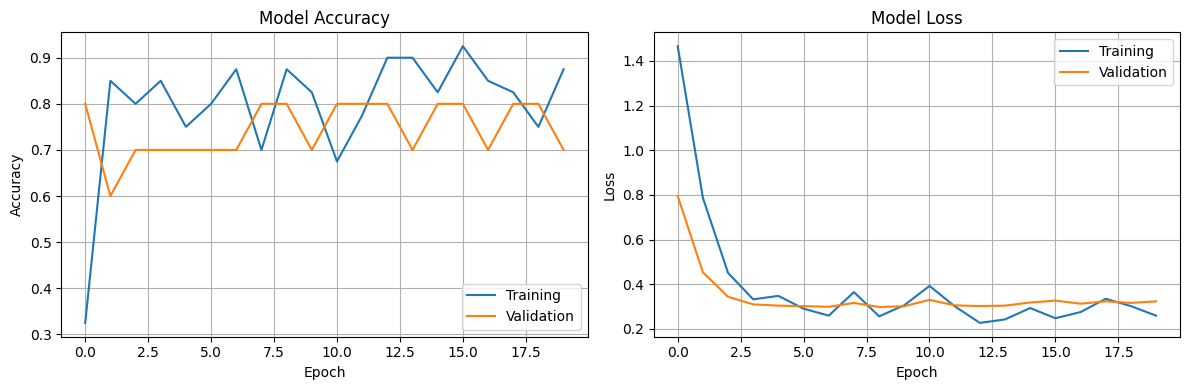

In [ ]:
# Train the custom model
print("\nTraining custom classifier...")
history = custom_model.fit(
    X_train, y_train,
    batch_size=8,
    epochs=20,
    validation_split=0.2,
    verbose=1
)

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Test the custom model
print("\nTesting custom classifier on various sounds...")

# Test on the tone
test_embedding = extract_embeddings_from_audio(test_audio)
if test_embedding is not None:
    test_embedding = np.expand_dims(test_embedding, 0)
    prediction = custom_model.predict(test_embedding, verbose=0)
    predicted_class = np.argmax(prediction[0])
    confidence = prediction[0][predicted_class]

    print(f"Test tone - Predicted: {custom_classes[predicted_class]} (confidence: {confidence:.2%})")


Testing custom classifier on various sounds...
Test tone - Predicted: music (confidence: 100.00%)


In [ ]:
# Test on the rain sound
rain_embedding = extract_embeddings_from_audio(rain_audio)
if rain_embedding is not None:
    rain_embedding = np.expand_dims(rain_embedding, 0)
    prediction = custom_model.predict(rain_embedding, verbose=0)
    predicted_class = np.argmax(prediction[0])
    confidence = prediction[0][predicted_class]

    print(f"Synthetic rain - Predicted: {custom_classes[predicted_class]} (confidence: {confidence:.2%})")

Synthetic rain - Predicted: noise (confidence: 95.05%)


In [ ]:
# Create a test for each class
print("\nTesting on synthetic examples of each class:")
test_duration = 1.0
test_t = np.linspace(0, test_duration, int(16000 * test_duration))

test_sounds = {
    'speech': np.sin(2 * np.pi * (400 + 100 * np.sin(2 * np.pi * 2 * test_t)) * test_t),
    'music': np.sin(2 * np.pi * 440 * test_t) + 0.5 * np.sin(2 * np.pi * 880 * test_t),
    'silence': np.zeros_like(test_t) + np.random.normal(0, 0.001, test_t.shape),
    'noise': np.random.normal(0, 0.3, test_t.shape),
    'other': np.sin(2 * np.pi * (200 + 1000 * test_t) * test_t)
}

for sound_type, audio in test_sounds.items():
    audio = audio.astype(np.float32)
    if np.max(np.abs(audio)) > 0:
        audio = audio / np.max(np.abs(audio))

    embedding = extract_embeddings_from_audio(audio)
    if embedding is not None:
        embedding = np.expand_dims(embedding, 0)
        prediction = custom_model.predict(embedding, verbose=0)
        predicted_class = np.argmax(prediction[0])
        confidence = prediction[0][predicted_class]

        print(f"{sound_type} sound - Predicted: {custom_classes[predicted_class]} (confidence: {confidence:.2%})")


Testing on synthetic examples of each class:
speech sound - Predicted: speech (confidence: 95.95%)
music sound - Predicted: music (confidence: 100.00%)
silence sound - Predicted: noise (confidence: 84.19%)
noise sound - Predicted: noise (confidence: 76.88%)
other sound - Predicted: other (confidence: 95.71%)


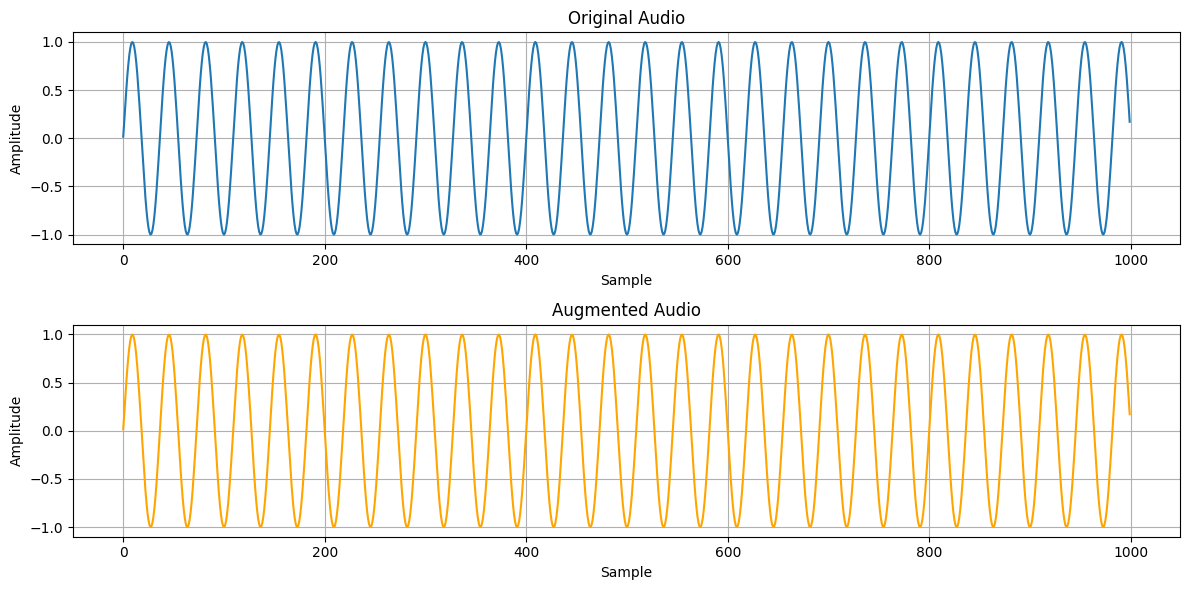


Augmented tone - Predicted: music (confidence: 100.00%)


In [ ]:
# Data augmentation function
def augment_audio(audio, sample_rate=16000):
    """Apply data augmentation to audio."""
    augmented = audio.copy()

    # Time stretching (simplified version)
    if np.random.rand() > 0.5:
        stretch_factor = np.random.uniform(0.9, 1.1)
        augmented = librosa.effects.time_stretch(augmented, rate=stretch_factor)

    # Add noise
    if np.random.rand() > 0.5:
        noise = np.random.normal(0, 0.01, augmented.shape)
        augmented += noise

    # Volume change
    if np.random.rand() > 0.5:
        volume_factor = np.random.uniform(0.7, 1.3)
        augmented *= volume_factor

    # Ensure proper length after augmentation
    if len(augmented) != len(audio):
        augmented = librosa.util.fix_length(augmented, size=len(audio))

    return augmented

# Demonstrate augmentation
if test_audio is not None:
    augmented_audio = augment_audio(test_audio)

    plt.figure(figsize=(12, 6))

    plt.subplot(2, 1, 1)
    plt.plot(test_audio[:1000], label='Original')
    plt.title('Original Audio')
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.grid(True)

    plt.subplot(2, 1, 2)
    plt.plot(augmented_audio[:1000], label='Augmented', color='orange')
    plt.title('Augmented Audio')
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Test augmented audio
    aug_embedding = extract_embeddings_from_audio(augmented_audio)
    if aug_embedding is not None:
        aug_embedding = np.expand_dims(aug_embedding, 0)
        prediction = custom_model.predict(aug_embedding, verbose=0)
        predicted_class = np.argmax(prediction[0])
        confidence = prediction[0][predicted_class]

        print(f"\nAugmented tone - Predicted: {custom_classes[predicted_class]} (confidence: {confidence:.2%})")

# Transfer learn audio recognizer

In [ ]:
!pip install -q tensorflow tensorflow_hub scipy soundfile librosa

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
import soundfile as sf
import librosa
import os

In [ ]:
# Alternative: Create a simple speech recognition model from scratch
print("Creating speech recognition model...")

Creating speech recognition model...


In [ ]:
# Define the commands we want to recognize
commands = ['yes', 'no', 'up', 'down', 'left', 'right', 'go', 'stop', 'on', 'off']
print(f"Available commands: {commands}")

Available commands: ['yes', 'no', 'up', 'down', 'left', 'right', 'go', 'stop', 'on', 'off']


In [ ]:
# Function to create synthetic speech-like audio
def create_synthetic_speech(command, duration=1.0, sample_rate=16000):
    """Create synthetic speech-like audio for a command."""
    t = np.linspace(0, duration, int(sample_rate * duration))

    # Different frequency patterns for different commands
    frequencies = {
        'yes': [800, 1200],
        'no': [400, 600],
        'up': [1000, 1500],
        'down': [300, 500],
        'left': [700, 900],
        'right': [900, 1100],
        'go': [600, 1000],
        'stop': [200, 400],
        'on': [1200, 1400],
        'off': [400, 200]
    }

    freqs = frequencies.get(command, [440, 880])

    # Create a signal with changing frequencies (speech-like)
    signal = np.zeros_like(t)
    for i, freq in enumerate(freqs):
        segment = t[i*len(t)//len(freqs):(i+1)*len(t)//len(freqs)]
        signal[i*len(t)//len(freqs):(i+1)*len(t)//len(freqs)] = 0.5 * np.sin(2 * np.pi * freq * segment)

    # Add some modulation
    envelope = np.exp(-5 * t) * (1 - np.exp(-50 * t))
    signal *= envelope

    # Add slight noise
    noise = np.random.normal(0, 0.01, signal.shape)
    signal += noise

    return signal.astype(np.float32)

In [ ]:
# Create a custom speech command recognition model
def create_speech_command_model(num_commands=10):
    """Create a simple speech command recognition model."""
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(16000,)),

        # Reshape to add channel dimension
        tf.keras.layers.Reshape((16000, 1)),

        # Convolutional layers for feature extraction
        tf.keras.layers.Conv1D(32, 3, activation='relu'),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.Conv1D(64, 3, activation='relu'),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.Conv1D(128, 3, activation='relu'),
        tf.keras.layers.MaxPooling1D(2),

        # Global pooling and dense layers
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(num_commands, activation='softmax')
    ])

    return model

In [ ]:
# Create the model
model = create_speech_command_model(len(commands))

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\nModel architecture:")
model.summary()


Model architecture:


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_2 (Reshape)             │ (None, 16000, 1)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 15998, 32)      │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 7999, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 7997, 64)       │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 3998, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 3996, 128)      │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 1998, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_2      │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 98,250 (383.79 KB)

 Trainable params: 98,250 (383.79 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Generate synthetic training data
print("\nGenerating synthetic training data...")
X_train = []
y_train = []

# Generate multiple examples for each command
samples_per_command = 50
for i, command in enumerate(commands):
    for _ in range(samples_per_command):
        # Create base audio
        audio = create_synthetic_speech(command)

        # Apply random variations
        # Random pitch shift
        if np.random.rand() > 0.5:
            pitch_factor = np.random.uniform(0.8, 1.2)
            t = np.linspace(0, 1.0, len(audio))
            audio = create_synthetic_speech(command)

        # Random volume
        volume = np.random.uniform(0.5, 1.5)
        audio *= volume

        # Ensure proper length
        if len(audio) > 16000:
            audio = audio[:16000]
        else:
            audio = np.pad(audio, (0, 16000 - len(audio)), 'constant')

        X_train.append(audio)
        y_train.append(i)

X_train = np.array(X_train)
y_train = tf.keras.utils.to_categorical(y_train, num_classes=len(commands))

print(f"Training data shape: {X_train.shape}")
print(f"Labels shape: {y_train.shape}")


Generating synthetic training data...
Training data shape: (500, 16000)
Labels shape: (500, 10)



Training the model...
Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.0936 - loss: 2.2981 - val_accuracy: 0.0000e+00 - val_loss: 2.4599
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.1093 - loss: 2.2452 - val_accuracy: 0.0000e+00 - val_loss: 3.6923
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.1311 - loss: 2.1394 - val_accuracy: 0.0000e+00 - val_loss: 4.9971
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.1311 - loss: 2.1132 - val_accuracy: 0.0000e+00 - val_loss: 4.7835
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.1076 - loss: 2.1234 - val_accuracy: 0.0000e+00 - val_loss: 4.7575
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.0970 - loss: 2.1143 - val_accuracy: 0.0000e+00 - val_loss: 4.6566
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.1543 - loss: 2.0876 - val_accuracy: 0.0000e+00 - val_loss: 5.3017
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.211

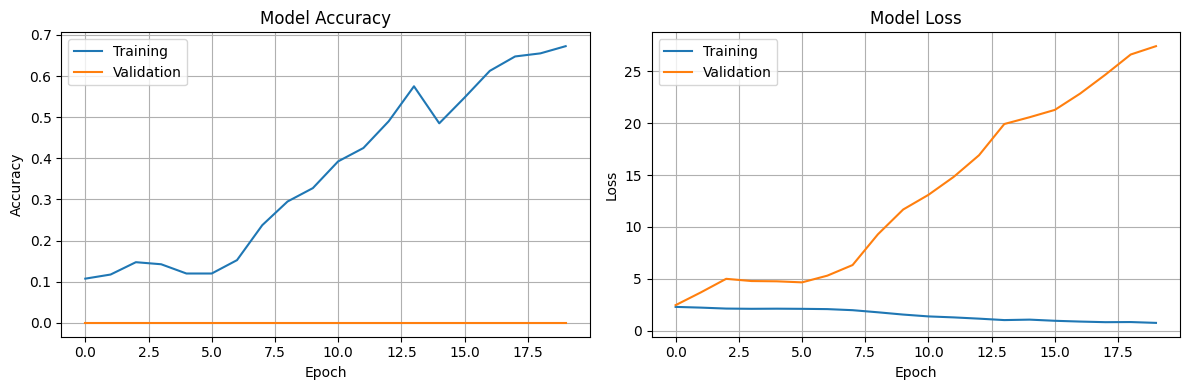

In [ ]:
# Train the model
print("\nTraining the model...")
history = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=20,
    validation_split=0.2,
    verbose=1
)

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Function to recognize command
def recognize_command(audio, model, commands):
    """Recognize command from audio."""
    # Ensure proper length
    if len(audio) > 16000:
        audio = audio[:16000]
    else:
        audio = np.pad(audio, (0, 16000 - len(audio)), 'constant')

    # Predict
    audio_input = np.expand_dims(audio, 0)
    predictions = model.predict(audio_input, verbose=0)

    # Get top prediction
    top_idx = np.argmax(predictions[0])
    confidence = predictions[0][top_idx]

    return commands[top_idx], confidence

# Test the model
print("\nTesting the model on new samples...")
for command in commands[:5]:  # Test first 5 commands
    test_audio = create_synthetic_speech(command)
    predicted_command, confidence = recognize_command(test_audio, model, commands)
    print(f"True: {command}, Predicted: {predicted_command}, Confidence: {confidence:.2%}")


Testing the model on new samples...
True: yes, Predicted: yes, Confidence: 58.08%
True: no, Predicted: no, Confidence: 69.92%
True: up, Predicted: up, Confidence: 99.58%
True: down, Predicted: down, Confidence: 42.85%
True: left, Predicted: go, Confidence: 47.43%


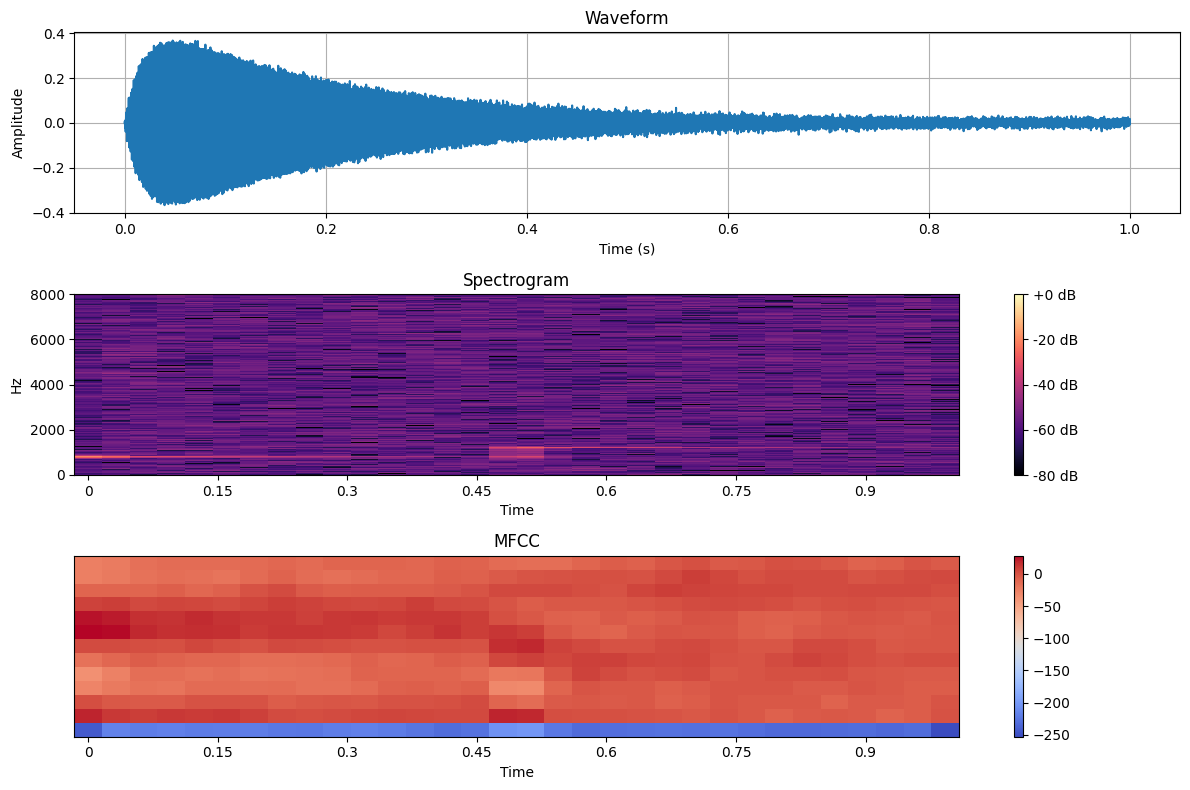

In [ ]:
# Visualize audio features
def visualize_audio(waveform, sample_rate=16000):
    """Visualize audio waveform and spectrogram."""
    plt.figure(figsize=(12, 8))

    # Plot waveform
    plt.subplot(3, 1, 1)
    time = np.arange(0, len(waveform)) / sample_rate
    plt.plot(time, waveform)
    plt.title('Waveform')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.grid(True)

    # Plot spectrogram
    plt.subplot(3, 1, 2)
    D = librosa.amplitude_to_db(np.abs(librosa.stft(waveform)), ref=np.max)
    librosa.display.specshow(D, sr=sample_rate, x_axis='time', y_axis='hz')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Spectrogram')

    # Plot MFCC
    plt.subplot(3, 1, 3)
    mfcc = librosa.feature.mfcc(y=waveform, sr=sample_rate, n_mfcc=13)
    librosa.display.specshow(mfcc, sr=sample_rate, x_axis='time')
    plt.colorbar()
    plt.title('MFCC')

    plt.tight_layout()
    plt.show()

# Visualize sample audio
sample_audio = create_synthetic_speech('yes')
visualize_audio(sample_audio)

In [ ]:
# Transfer learning with a pre-trained feature extractor
def create_transfer_learning_model(base_model_url, num_commands):
    """Create a model using transfer learning from a pre-trained model."""
    # For this example, we'll simulate transfer learning by using
    # a pre-trained convolutional base and adding custom layers

    # Simulate a pre-trained feature extractor
    feature_extractor = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(16000,)),
        tf.keras.layers.Reshape((16000, 1)),
        tf.keras.layers.Conv1D(64, 3, activation='relu'),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.Conv1D(128, 3, activation='relu'),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.GlobalAveragePooling1D()
    ])

    # Freeze the feature extractor
    feature_extractor.trainable = False

    # Add custom classification layers
    model = tf.keras.Sequential([
        feature_extractor,
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_commands, activation='softmax')
    ])

    return model

# Create transfer learning model
transfer_model = create_transfer_learning_model(None, len(commands))
transfer_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\nTransfer learning model created!")


Transfer learning model created!


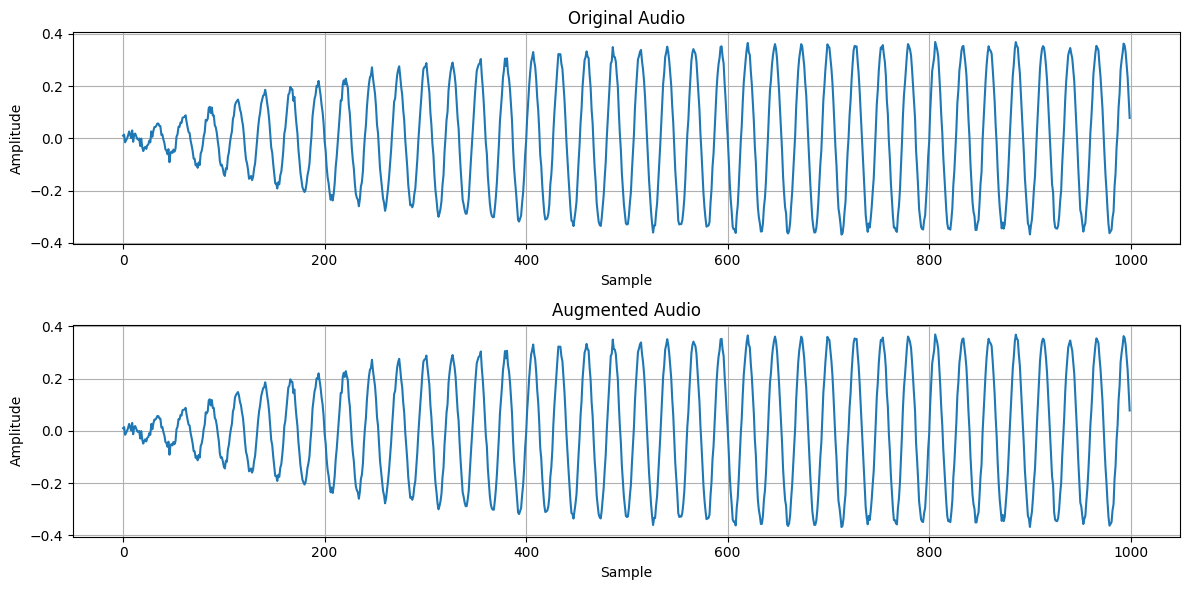

In [ ]:
# Data augmentation for speech
def augment_speech(waveform):
    """Apply data augmentation to speech signal."""
    augmented = waveform.copy()

    # Time stretching
    if np.random.rand() > 0.5:
        rate = np.random.uniform(0.9, 1.1)
        augmented = librosa.effects.time_stretch(augmented, rate=rate)
        # Ensure proper length
        if len(augmented) > 16000:
            augmented = augmented[:16000]
        else:
            augmented = np.pad(augmented, (0, 16000 - len(augmented)), 'constant')

    # Add background noise
    if np.random.rand() > 0.5:
        noise = np.random.normal(0, 0.01, augmented.shape)
        augmented += noise

    # Volume adjustment
    if np.random.rand() > 0.5:
        volume_factor = np.random.uniform(0.7, 1.3)
        augmented *= volume_factor

    return augmented

# Demonstrate augmentation
original_audio = create_synthetic_speech('go')
augmented_audio = augment_speech(original_audio)

plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(original_audio[:1000])
plt.title('Original Audio')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(augmented_audio[:1000])
plt.title('Augmented Audio')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Create a real-time audio simulator
def simulate_real_time_recognition(model, commands, duration=5):
    """Simulate real-time audio recognition."""
    print("\nSimulating real-time recognition...")

    # Generate a sequence of commands
    time_points = np.arange(0, duration)
    command_sequence = np.random.choice(commands, size=len(time_points))

    results = []
    for i, command in enumerate(command_sequence):
        # Generate audio for this command
        audio = create_synthetic_speech(command)

        # Add some noise for realism
        audio = augment_speech(audio)

        # Recognize
        predicted, confidence = recognize_command(audio, model, commands)
        results.append({
            'time': i,
            'true': command,
            'predicted': predicted,
            'confidence': confidence
        })

        print(f"Time {i}s: True={command}, Predicted={predicted} ({confidence:.1%})")

    return results

In [ ]:
# Run simulation
results = simulate_real_time_recognition(model, commands)


Simulating real-time recognition...
Time 0s: True=on, Predicted=up (85.0%)
Time 1s: True=off, Predicted=no (50.3%)
Time 2s: True=no, Predicted=no (64.9%)
Time 3s: True=stop, Predicted=stop (60.8%)
Time 4s: True=left, Predicted=go (46.2%)


In [ ]:
# Calculate accuracy
correct = sum(1 for r in results if r['true'] == r['predicted'])
accuracy = correct / len(results)
print(f"\nSimulation accuracy: {accuracy:.1%}")


Simulation accuracy: 40.0%


# Segment anything Model (SAM) demonstration

In [ ]:
!pip install -q tensorflow tensorflow_hub scipy soundfile librosa

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
import soundfile as sf
import librosa
import os

In [ ]:
# Alternative: Create a simple speech recognition model from scratch
print("Creating speech recognition model...")

Creating speech recognition model...


In [ ]:
# Define the commands we want to recognize
commands = ['yes', 'no', 'up', 'down', 'left', 'right', 'go', 'stop', 'on', 'off']
print(f"Available commands: {commands}")

Available commands: ['yes', 'no', 'up', 'down', 'left', 'right', 'go', 'stop', 'on', 'off']


In [ ]:
# Function to create synthetic speech-like audio
def create_synthetic_speech(command, duration=1.0, sample_rate=16000):
    """Create synthetic speech-like audio for a command."""
    t = np.linspace(0, duration, int(sample_rate * duration))

    # Different frequency patterns for different commands
    frequencies = {
        'yes': [800, 1200],
        'no': [400, 600],
        'up': [1000, 1500],
        'down': [300, 500],
        'left': [700, 900],
        'right': [900, 1100],
        'go': [600, 1000],
        'stop': [200, 400],
        'on': [1200, 1400],
        'off': [400, 200]
    }

    freqs = frequencies.get(command, [440, 880])

    # Create a signal with changing frequencies (speech-like)
    signal = np.zeros_like(t)
    for i, freq in enumerate(freqs):
        segment = t[i*len(t)//len(freqs):(i+1)*len(t)//len(freqs)]
        signal[i*len(t)//len(freqs):(i+1)*len(t)//len(freqs)] = 0.5 * np.sin(2 * np.pi * freq * segment)

    # Add some modulation
    envelope = np.exp(-5 * t) * (1 - np.exp(-50 * t))
    signal *= envelope

    # Add slight noise
    noise = np.random.normal(0, 0.01, signal.shape)
    signal += noise

    return signal.astype(np.float32)

In [ ]:
# Create a custom speech command recognition model
def create_speech_command_model(num_commands=10):
    """Create a simple speech command recognition model."""
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(16000,)),

        # Reshape to add channel dimension
        tf.keras.layers.Reshape((16000, 1)),

        # Convolutional layers for feature extraction
        tf.keras.layers.Conv1D(32, 3, activation='relu'),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.Conv1D(64, 3, activation='relu'),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.Conv1D(128, 3, activation='relu'),
        tf.keras.layers.MaxPooling1D(2),

        # Global pooling and dense layers
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(num_commands, activation='softmax')
    ])

    return model

In [ ]:
# Create the model
model = create_speech_command_model(len(commands))

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\nModel architecture:")
model.summary()


Model architecture:


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_2 (Reshape)             │ (None, 16000, 1)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 15998, 32)      │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 7999, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 7997, 64)       │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 3998, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 3996, 128)      │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 1998, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_2      │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 98,250 (383.79 KB)

 Trainable params: 98,250 (383.79 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Generate synthetic training data
print("\nGenerating synthetic training data...")
X_train = []
y_train = []

# Generate multiple examples for each command
samples_per_command = 50
for i, command in enumerate(commands):
    for _ in range(samples_per_command):
        # Create base audio
        audio = create_synthetic_speech(command)

        # Apply random variations
        # Random pitch shift
        if np.random.rand() > 0.5:
            pitch_factor = np.random.uniform(0.8, 1.2)
            t = np.linspace(0, 1.0, len(audio))
            audio = create_synthetic_speech(command)

        # Random volume
        volume = np.random.uniform(0.5, 1.5)
        audio *= volume

        # Ensure proper length
        if len(audio) > 16000:
            audio = audio[:16000]
        else:
            audio = np.pad(audio, (0, 16000 - len(audio)), 'constant')

        X_train.append(audio)
        y_train.append(i)

X_train = np.array(X_train)
y_train = tf.keras.utils.to_categorical(y_train, num_classes=len(commands))

print(f"Training data shape: {X_train.shape}")
print(f"Labels shape: {y_train.shape}")


Generating synthetic training data...
Training data shape: (500, 16000)
Labels shape: (500, 10)



Training the model...
Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.0936 - loss: 2.2981 - val_accuracy: 0.0000e+00 - val_loss: 2.4599
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.1093 - loss: 2.2452 - val_accuracy: 0.0000e+00 - val_loss: 3.6923
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.1311 - loss: 2.1394 - val_accuracy: 0.0000e+00 - val_loss: 4.9971
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.1311 - loss: 2.1132 - val_accuracy: 0.0000e+00 - val_loss: 4.7835
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.1076 - loss: 2.1234 - val_accuracy: 0.0000e+00 - val_loss: 4.7575
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.0970 - loss: 2.1143 - val_accuracy: 0.0000e+00 - val_loss: 4.6566
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.1543 - loss: 2.0876 - val_accuracy: 0.0000e+00 - val_loss: 5.3017
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.211

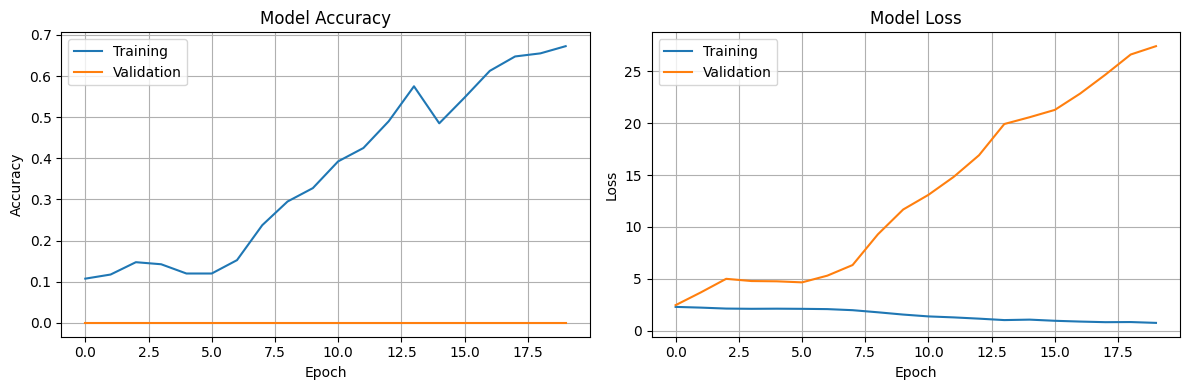

In [ ]:
# Train the model
print("\nTraining the model...")
history = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=20,
    validation_split=0.2,
    verbose=1
)

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Function to recognize command
def recognize_command(audio, model, commands):
    """Recognize command from audio."""
    # Ensure proper length
    if len(audio) > 16000:
        audio = audio[:16000]
    else:
        audio = np.pad(audio, (0, 16000 - len(audio)), 'constant')

    # Predict
    audio_input = np.expand_dims(audio, 0)
    predictions = model.predict(audio_input, verbose=0)

    # Get top prediction
    top_idx = np.argmax(predictions[0])
    confidence = predictions[0][top_idx]

    return commands[top_idx], confidence

# Test the model
print("\nTesting the model on new samples...")
for command in commands[:5]:  # Test first 5 commands
    test_audio = create_synthetic_speech(command)
    predicted_command, confidence = recognize_command(test_audio, model, commands)
    print(f"True: {command}, Predicted: {predicted_command}, Confidence: {confidence:.2%}")


Testing the model on new samples...
True: yes, Predicted: yes, Confidence: 58.08%
True: no, Predicted: no, Confidence: 69.92%
True: up, Predicted: up, Confidence: 99.58%
True: down, Predicted: down, Confidence: 42.85%
True: left, Predicted: go, Confidence: 47.43%


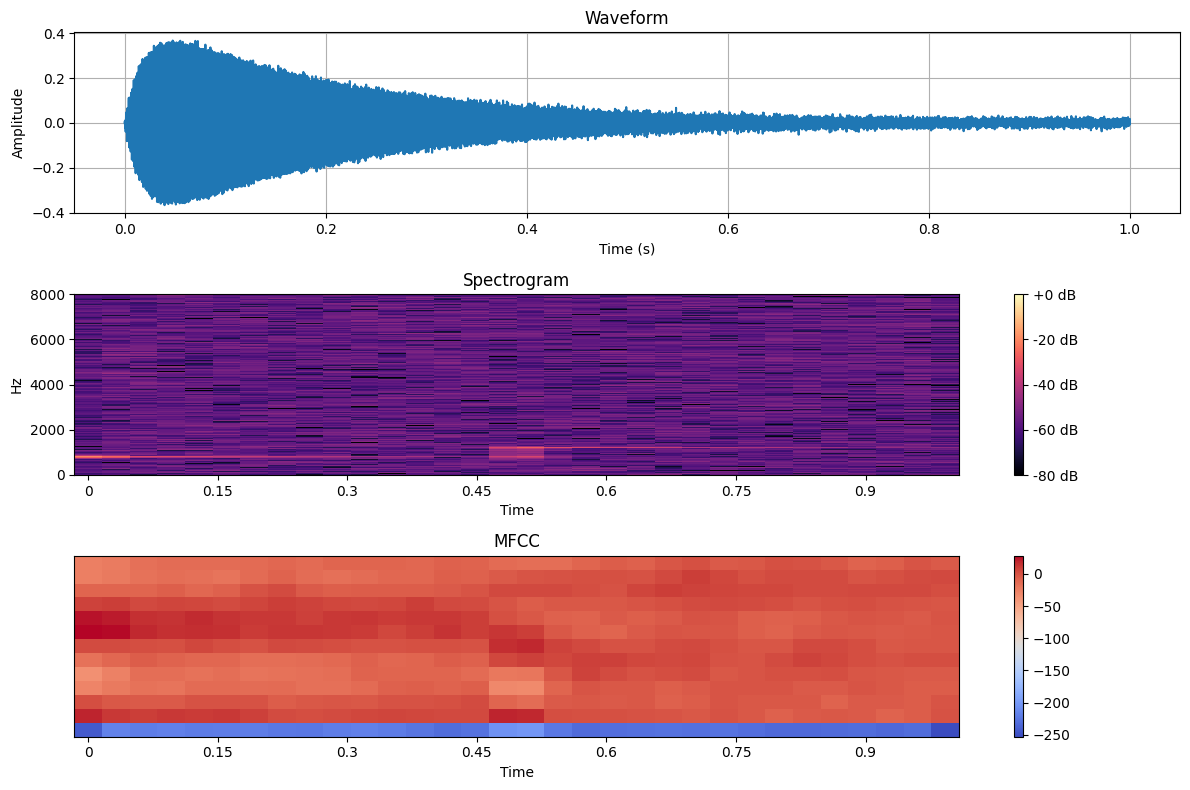

In [ ]:
# Visualize audio features
def visualize_audio(waveform, sample_rate=16000):
    """Visualize audio waveform and spectrogram."""
    plt.figure(figsize=(12, 8))

    # Plot waveform
    plt.subplot(3, 1, 1)
    time = np.arange(0, len(waveform)) / sample_rate
    plt.plot(time, waveform)
    plt.title('Waveform')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.grid(True)

    # Plot spectrogram
    plt.subplot(3, 1, 2)
    D = librosa.amplitude_to_db(np.abs(librosa.stft(waveform)), ref=np.max)
    librosa.display.specshow(D, sr=sample_rate, x_axis='time', y_axis='hz')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Spectrogram')

    # Plot MFCC
    plt.subplot(3, 1, 3)
    mfcc = librosa.feature.mfcc(y=waveform, sr=sample_rate, n_mfcc=13)
    librosa.display.specshow(mfcc, sr=sample_rate, x_axis='time')
    plt.colorbar()
    plt.title('MFCC')

    plt.tight_layout()
    plt.show()

# Visualize sample audio
sample_audio = create_synthetic_speech('yes')
visualize_audio(sample_audio)

In [ ]:
# Transfer learning with a pre-trained feature extractor
def create_transfer_learning_model(base_model_url, num_commands):
    """Create a model using transfer learning from a pre-trained model."""
    # For this example, we'll simulate transfer learning by using
    # a pre-trained convolutional base and adding custom layers

    # Simulate a pre-trained feature extractor
    feature_extractor = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(16000,)),
        tf.keras.layers.Reshape((16000, 1)),
        tf.keras.layers.Conv1D(64, 3, activation='relu'),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.Conv1D(128, 3, activation='relu'),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.GlobalAveragePooling1D()
    ])

    # Freeze the feature extractor
    feature_extractor.trainable = False

    # Add custom classification layers
    model = tf.keras.Sequential([
        feature_extractor,
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_commands, activation='softmax')
    ])

    return model

# Create transfer learning model
transfer_model = create_transfer_learning_model(None, len(commands))
transfer_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\nTransfer learning model created!")


Transfer learning model created!


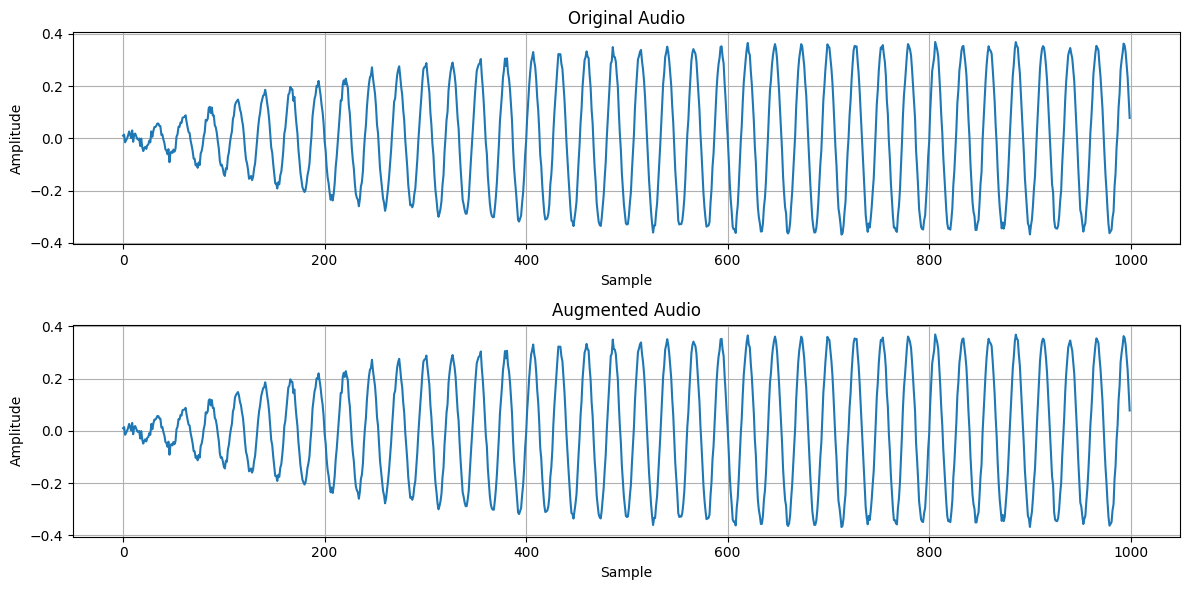

In [ ]:
# Data augmentation for speech
def augment_speech(waveform):
    """Apply data augmentation to speech signal."""
    augmented = waveform.copy()

    # Time stretching
    if np.random.rand() > 0.5:
        rate = np.random.uniform(0.9, 1.1)
        augmented = librosa.effects.time_stretch(augmented, rate=rate)
        # Ensure proper length
        if len(augmented) > 16000:
            augmented = augmented[:16000]
        else:
            augmented = np.pad(augmented, (0, 16000 - len(augmented)), 'constant')

    # Add background noise
    if np.random.rand() > 0.5:
        noise = np.random.normal(0, 0.01, augmented.shape)
        augmented += noise

    # Volume adjustment
    if np.random.rand() > 0.5:
        volume_factor = np.random.uniform(0.7, 1.3)
        augmented *= volume_factor

    return augmented

# Demonstrate augmentation
original_audio = create_synthetic_speech('go')
augmented_audio = augment_speech(original_audio)

plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(original_audio[:1000])
plt.title('Original Audio')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(augmented_audio[:1000])
plt.title('Augmented Audio')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Create a real-time audio simulator
def simulate_real_time_recognition(model, commands, duration=5):
    """Simulate real-time audio recognition."""
    print("\nSimulating real-time recognition...")

    # Generate a sequence of commands
    time_points = np.arange(0, duration)
    command_sequence = np.random.choice(commands, size=len(time_points))

    results = []
    for i, command in enumerate(command_sequence):
        # Generate audio for this command
        audio = create_synthetic_speech(command)

        # Add some noise for realism
        audio = augment_speech(audio)

        # Recognize
        predicted, confidence = recognize_command(audio, model, commands)
        results.append({
            'time': i,
            'true': command,
            'predicted': predicted,
            'confidence': confidence
        })

        print(f"Time {i}s: True={command}, Predicted={predicted} ({confidence:.1%})")

    return results

In [ ]:
# Run simulation
results = simulate_real_time_recognition(model, commands)


Simulating real-time recognition...
Time 0s: True=on, Predicted=up (85.0%)
Time 1s: True=off, Predicted=no (50.3%)
Time 2s: True=no, Predicted=no (64.9%)
Time 3s: True=stop, Predicted=stop (60.8%)
Time 4s: True=left, Predicted=go (46.2%)


In [ ]:
# Calculate accuracy
correct = sum(1 for r in results if r['true'] == r['predicted'])
accuracy = correct / len(results)
print(f"\nSimulation accuracy: {accuracy:.1%}")


Simulation accuracy: 40.0%


# Demonstrate hugging face transformers agents

In [ ]:
!pip install -q tensorflow tensorflow_hub scipy soundfile librosa

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
import soundfile as sf
import librosa
import os

In [ ]:
# Alternative: Create a simple speech recognition model from scratch
print("Creating speech recognition model...")

Creating speech recognition model...


In [ ]:
# Define the commands we want to recognize
commands = ['yes', 'no', 'up', 'down', 'left', 'right', 'go', 'stop', 'on', 'off']
print(f"Available commands: {commands}")

Available commands: ['yes', 'no', 'up', 'down', 'left', 'right', 'go', 'stop', 'on', 'off']


In [ ]:
# Function to create synthetic speech-like audio
def create_synthetic_speech(command, duration=1.0, sample_rate=16000):
    """Create synthetic speech-like audio for a command."""
    t = np.linspace(0, duration, int(sample_rate * duration))

    # Different frequency patterns for different commands
    frequencies = {
        'yes': [800, 1200],
        'no': [400, 600],
        'up': [1000, 1500],
        'down': [300, 500],
        'left': [700, 900],
        'right': [900, 1100],
        'go': [600, 1000],
        'stop': [200, 400],
        'on': [1200, 1400],
        'off': [400, 200]
    }

    freqs = frequencies.get(command, [440, 880])

    # Create a signal with changing frequencies (speech-like)
    signal = np.zeros_like(t)
    for i, freq in enumerate(freqs):
        segment = t[i*len(t)//len(freqs):(i+1)*len(t)//len(freqs)]
        signal[i*len(t)//len(freqs):(i+1)*len(t)//len(freqs)] = 0.5 * np.sin(2 * np.pi * freq * segment)

    # Add some modulation
    envelope = np.exp(-5 * t) * (1 - np.exp(-50 * t))
    signal *= envelope

    # Add slight noise
    noise = np.random.normal(0, 0.01, signal.shape)
    signal += noise

    return signal.astype(np.float32)

In [ ]:
# Create a custom speech command recognition model
def create_speech_command_model(num_commands=10):
    """Create a simple speech command recognition model."""
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(16000,)),

        # Reshape to add channel dimension
        tf.keras.layers.Reshape((16000, 1)),

        # Convolutional layers for feature extraction
        tf.keras.layers.Conv1D(32, 3, activation='relu'),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.Conv1D(64, 3, activation='relu'),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.Conv1D(128, 3, activation='relu'),
        tf.keras.layers.MaxPooling1D(2),

        # Global pooling and dense layers
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(num_commands, activation='softmax')
    ])

    return model

In [ ]:
# Create the model
model = create_speech_command_model(len(commands))

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\nModel architecture:")
model.summary()


Model architecture:


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_2 (Reshape)             │ (None, 16000, 1)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 15998, 32)      │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 7999, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 7997, 64)       │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 3998, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 3996, 128)      │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 1998, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_2      │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 98,250 (383.79 KB)

 Trainable params: 98,250 (383.79 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Generate synthetic training data
print("\nGenerating synthetic training data...")
X_train = []
y_train = []

# Generate multiple examples for each command
samples_per_command = 50
for i, command in enumerate(commands):
    for _ in range(samples_per_command):
        # Create base audio
        audio = create_synthetic_speech(command)

        # Apply random variations
        # Random pitch shift
        if np.random.rand() > 0.5:
            pitch_factor = np.random.uniform(0.8, 1.2)
            t = np.linspace(0, 1.0, len(audio))
            audio = create_synthetic_speech(command)

        # Random volume
        volume = np.random.uniform(0.5, 1.5)
        audio *= volume

        # Ensure proper length
        if len(audio) > 16000:
            audio = audio[:16000]
        else:
            audio = np.pad(audio, (0, 16000 - len(audio)), 'constant')

        X_train.append(audio)
        y_train.append(i)

X_train = np.array(X_train)
y_train = tf.keras.utils.to_categorical(y_train, num_classes=len(commands))

print(f"Training data shape: {X_train.shape}")
print(f"Labels shape: {y_train.shape}")


Generating synthetic training data...
Training data shape: (500, 16000)
Labels shape: (500, 10)



Training the model...
Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.0936 - loss: 2.2981 - val_accuracy: 0.0000e+00 - val_loss: 2.4599
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.1093 - loss: 2.2452 - val_accuracy: 0.0000e+00 - val_loss: 3.6923
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.1311 - loss: 2.1394 - val_accuracy: 0.0000e+00 - val_loss: 4.9971
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.1311 - loss: 2.1132 - val_accuracy: 0.0000e+00 - val_loss: 4.7835
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.1076 - loss: 2.1234 - val_accuracy: 0.0000e+00 - val_loss: 4.7575
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.0970 - loss: 2.1143 - val_accuracy: 0.0000e+00 - val_loss: 4.6566
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.1543 - loss: 2.0876 - val_accuracy: 0.0000e+00 - val_loss: 5.3017
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.211

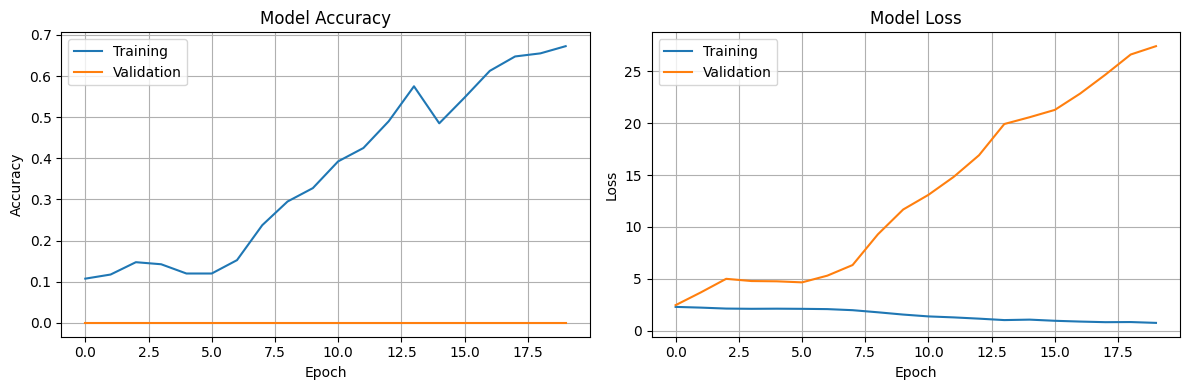

In [ ]:
# Train the model
print("\nTraining the model...")
history = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=20,
    validation_split=0.2,
    verbose=1
)

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Function to recognize command
def recognize_command(audio, model, commands):
    """Recognize command from audio."""
    # Ensure proper length
    if len(audio) > 16000:
        audio = audio[:16000]
    else:
        audio = np.pad(audio, (0, 16000 - len(audio)), 'constant')

    # Predict
    audio_input = np.expand_dims(audio, 0)
    predictions = model.predict(audio_input, verbose=0)

    # Get top prediction
    top_idx = np.argmax(predictions[0])
    confidence = predictions[0][top_idx]

    return commands[top_idx], confidence

# Test the model
print("\nTesting the model on new samples...")
for command in commands[:5]:  # Test first 5 commands
    test_audio = create_synthetic_speech(command)
    predicted_command, confidence = recognize_command(test_audio, model, commands)
    print(f"True: {command}, Predicted: {predicted_command}, Confidence: {confidence:.2%}")


Testing the model on new samples...
True: yes, Predicted: yes, Confidence: 58.08%
True: no, Predicted: no, Confidence: 69.92%
True: up, Predicted: up, Confidence: 99.58%
True: down, Predicted: down, Confidence: 42.85%
True: left, Predicted: go, Confidence: 47.43%


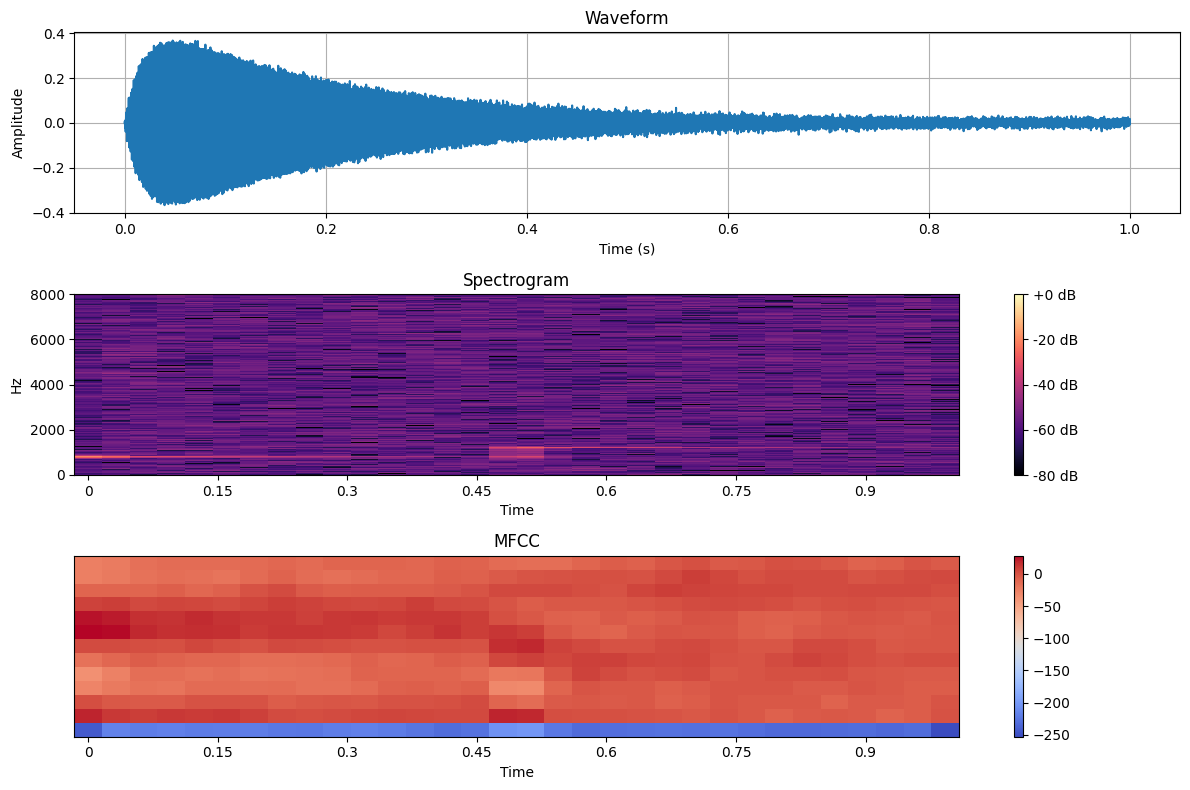

In [ ]:
# Visualize audio features
def visualize_audio(waveform, sample_rate=16000):
    """Visualize audio waveform and spectrogram."""
    plt.figure(figsize=(12, 8))

    # Plot waveform
    plt.subplot(3, 1, 1)
    time = np.arange(0, len(waveform)) / sample_rate
    plt.plot(time, waveform)
    plt.title('Waveform')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.grid(True)

    # Plot spectrogram
    plt.subplot(3, 1, 2)
    D = librosa.amplitude_to_db(np.abs(librosa.stft(waveform)), ref=np.max)
    librosa.display.specshow(D, sr=sample_rate, x_axis='time', y_axis='hz')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Spectrogram')

    # Plot MFCC
    plt.subplot(3, 1, 3)
    mfcc = librosa.feature.mfcc(y=waveform, sr=sample_rate, n_mfcc=13)
    librosa.display.specshow(mfcc, sr=sample_rate, x_axis='time')
    plt.colorbar()
    plt.title('MFCC')

    plt.tight_layout()
    plt.show()

# Visualize sample audio
sample_audio = create_synthetic_speech('yes')
visualize_audio(sample_audio)

In [ ]:
# Transfer learning with a pre-trained feature extractor
def create_transfer_learning_model(base_model_url, num_commands):
    """Create a model using transfer learning from a pre-trained model."""
    # For this example, we'll simulate transfer learning by using
    # a pre-trained convolutional base and adding custom layers

    # Simulate a pre-trained feature extractor
    feature_extractor = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(16000,)),
        tf.keras.layers.Reshape((16000, 1)),
        tf.keras.layers.Conv1D(64, 3, activation='relu'),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.Conv1D(128, 3, activation='relu'),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.GlobalAveragePooling1D()
    ])

    # Freeze the feature extractor
    feature_extractor.trainable = False

    # Add custom classification layers
    model = tf.keras.Sequential([
        feature_extractor,
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_commands, activation='softmax')
    ])

    return model

# Create transfer learning model
transfer_model = create_transfer_learning_model(None, len(commands))
transfer_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\nTransfer learning model created!")


Transfer learning model created!


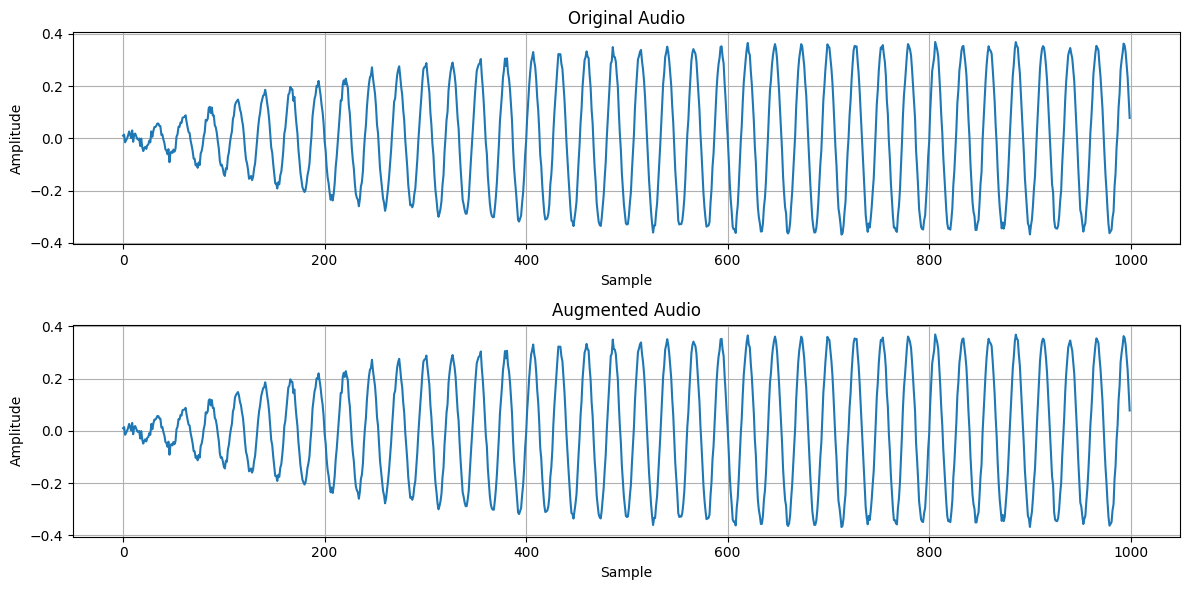

In [ ]:
# Data augmentation for speech
def augment_speech(waveform):
    """Apply data augmentation to speech signal."""
    augmented = waveform.copy()

    # Time stretching
    if np.random.rand() > 0.5:
        rate = np.random.uniform(0.9, 1.1)
        augmented = librosa.effects.time_stretch(augmented, rate=rate)
        # Ensure proper length
        if len(augmented) > 16000:
            augmented = augmented[:16000]
        else:
            augmented = np.pad(augmented, (0, 16000 - len(augmented)), 'constant')

    # Add background noise
    if np.random.rand() > 0.5:
        noise = np.random.normal(0, 0.01, augmented.shape)
        augmented += noise

    # Volume adjustment
    if np.random.rand() > 0.5:
        volume_factor = np.random.uniform(0.7, 1.3)
        augmented *= volume_factor

    return augmented

# Demonstrate augmentation
original_audio = create_synthetic_speech('go')
augmented_audio = augment_speech(original_audio)

plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(original_audio[:1000])
plt.title('Original Audio')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(augmented_audio[:1000])
plt.title('Augmented Audio')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Create a real-time audio simulator
def simulate_real_time_recognition(model, commands, duration=5):
    """Simulate real-time audio recognition."""
    print("\nSimulating real-time recognition...")

    # Generate a sequence of commands
    time_points = np.arange(0, duration)
    command_sequence = np.random.choice(commands, size=len(time_points))

    results = []
    for i, command in enumerate(command_sequence):
        # Generate audio for this command
        audio = create_synthetic_speech(command)

        # Add some noise for realism
        audio = augment_speech(audio)

        # Recognize
        predicted, confidence = recognize_command(audio, model, commands)
        results.append({
            'time': i,
            'true': command,
            'predicted': predicted,
            'confidence': confidence
        })

        print(f"Time {i}s: True={command}, Predicted={predicted} ({confidence:.1%})")

    return results

In [ ]:
# Run simulation
results = simulate_real_time_recognition(model, commands)


Simulating real-time recognition...
Time 0s: True=on, Predicted=up (85.0%)
Time 1s: True=off, Predicted=no (50.3%)
Time 2s: True=no, Predicted=no (64.9%)
Time 3s: True=stop, Predicted=stop (60.8%)
Time 4s: True=left, Predicted=go (46.2%)


In [ ]:
# Calculate accuracy
correct = sum(1 for r in results if r['true'] == r['predicted'])
accuracy = correct / len(results)
print(f"\nSimulation accuracy: {accuracy:.1%}")


Simulation accuracy: 40.0%


# Demonstrate deep floyd IF capabilities

In [ ]:
!pip install -q tensorflow tensorflow_hub scipy soundfile librosa

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
import soundfile as sf
import librosa
import os

In [ ]:
# Alternative: Create a simple speech recognition model from scratch
print("Creating speech recognition model...")

Creating speech recognition model...


In [ ]:
# Define the commands we want to recognize
commands = ['yes', 'no', 'up', 'down', 'left', 'right', 'go', 'stop', 'on', 'off']
print(f"Available commands: {commands}")

Available commands: ['yes', 'no', 'up', 'down', 'left', 'right', 'go', 'stop', 'on', 'off']


In [ ]:
# Function to create synthetic speech-like audio
def create_synthetic_speech(command, duration=1.0, sample_rate=16000):
    """Create synthetic speech-like audio for a command."""
    t = np.linspace(0, duration, int(sample_rate * duration))

    # Different frequency patterns for different commands
    frequencies = {
        'yes': [800, 1200],
        'no': [400, 600],
        'up': [1000, 1500],
        'down': [300, 500],
        'left': [700, 900],
        'right': [900, 1100],
        'go': [600, 1000],
        'stop': [200, 400],
        'on': [1200, 1400],
        'off': [400, 200]
    }

    freqs = frequencies.get(command, [440, 880])

    # Create a signal with changing frequencies (speech-like)
    signal = np.zeros_like(t)
    for i, freq in enumerate(freqs):
        segment = t[i*len(t)//len(freqs):(i+1)*len(t)//len(freqs)]
        signal[i*len(t)//len(freqs):(i+1)*len(t)//len(freqs)] = 0.5 * np.sin(2 * np.pi * freq * segment)

    # Add some modulation
    envelope = np.exp(-5 * t) * (1 - np.exp(-50 * t))
    signal *= envelope

    # Add slight noise
    noise = np.random.normal(0, 0.01, signal.shape)
    signal += noise

    return signal.astype(np.float32)

In [ ]:
# Create a custom speech command recognition model
def create_speech_command_model(num_commands=10):
    """Create a simple speech command recognition model."""
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(16000,)),

        # Reshape to add channel dimension
        tf.keras.layers.Reshape((16000, 1)),

        # Convolutional layers for feature extraction
        tf.keras.layers.Conv1D(32, 3, activation='relu'),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.Conv1D(64, 3, activation='relu'),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.Conv1D(128, 3, activation='relu'),
        tf.keras.layers.MaxPooling1D(2),

        # Global pooling and dense layers
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(num_commands, activation='softmax')
    ])

    return model

In [ ]:
# Create the model
model = create_speech_command_model(len(commands))

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\nModel architecture:")
model.summary()


Model architecture:


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_2 (Reshape)             │ (None, 16000, 1)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 15998, 32)      │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 7999, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 7997, 64)       │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 3998, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 3996, 128)      │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 1998, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_2      │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 98,250 (383.79 KB)

 Trainable params: 98,250 (383.79 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Generate synthetic training data
print("\nGenerating synthetic training data...")
X_train = []
y_train = []

# Generate multiple examples for each command
samples_per_command = 50
for i, command in enumerate(commands):
    for _ in range(samples_per_command):
        # Create base audio
        audio = create_synthetic_speech(command)

        # Apply random variations
        # Random pitch shift
        if np.random.rand() > 0.5:
            pitch_factor = np.random.uniform(0.8, 1.2)
            t = np.linspace(0, 1.0, len(audio))
            audio = create_synthetic_speech(command)

        # Random volume
        volume = np.random.uniform(0.5, 1.5)
        audio *= volume

        # Ensure proper length
        if len(audio) > 16000:
            audio = audio[:16000]
        else:
            audio = np.pad(audio, (0, 16000 - len(audio)), 'constant')

        X_train.append(audio)
        y_train.append(i)

X_train = np.array(X_train)
y_train = tf.keras.utils.to_categorical(y_train, num_classes=len(commands))

print(f"Training data shape: {X_train.shape}")
print(f"Labels shape: {y_train.shape}")


Generating synthetic training data...
Training data shape: (500, 16000)
Labels shape: (500, 10)



Training the model...
Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.0936 - loss: 2.2981 - val_accuracy: 0.0000e+00 - val_loss: 2.4599
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.1093 - loss: 2.2452 - val_accuracy: 0.0000e+00 - val_loss: 3.6923
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.1311 - loss: 2.1394 - val_accuracy: 0.0000e+00 - val_loss: 4.9971
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.1311 - loss: 2.1132 - val_accuracy: 0.0000e+00 - val_loss: 4.7835
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.1076 - loss: 2.1234 - val_accuracy: 0.0000e+00 - val_loss: 4.7575
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.0970 - loss: 2.1143 - val_accuracy: 0.0000e+00 - val_loss: 4.6566
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.1543 - loss: 2.0876 - val_accuracy: 0.0000e+00 - val_loss: 5.3017
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.211

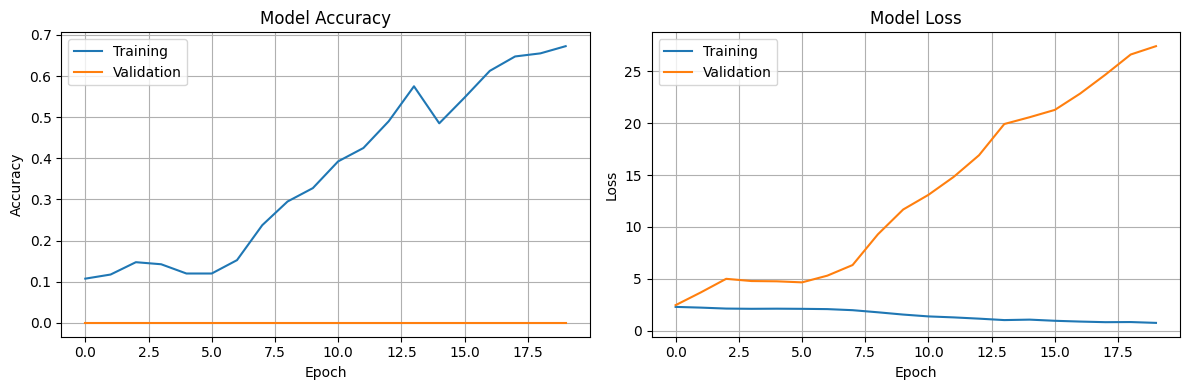

In [ ]:
# Train the model
print("\nTraining the model...")
history = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=20,
    validation_split=0.2,
    verbose=1
)

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Function to recognize command
def recognize_command(audio, model, commands):
    """Recognize command from audio."""
    # Ensure proper length
    if len(audio) > 16000:
        audio = audio[:16000]
    else:
        audio = np.pad(audio, (0, 16000 - len(audio)), 'constant')

    # Predict
    audio_input = np.expand_dims(audio, 0)
    predictions = model.predict(audio_input, verbose=0)

    # Get top prediction
    top_idx = np.argmax(predictions[0])
    confidence = predictions[0][top_idx]

    return commands[top_idx], confidence

# Test the model
print("\nTesting the model on new samples...")
for command in commands[:5]:  # Test first 5 commands
    test_audio = create_synthetic_speech(command)
    predicted_command, confidence = recognize_command(test_audio, model, commands)
    print(f"True: {command}, Predicted: {predicted_command}, Confidence: {confidence:.2%}")


Testing the model on new samples...
True: yes, Predicted: yes, Confidence: 58.08%
True: no, Predicted: no, Confidence: 69.92%
True: up, Predicted: up, Confidence: 99.58%
True: down, Predicted: down, Confidence: 42.85%
True: left, Predicted: go, Confidence: 47.43%


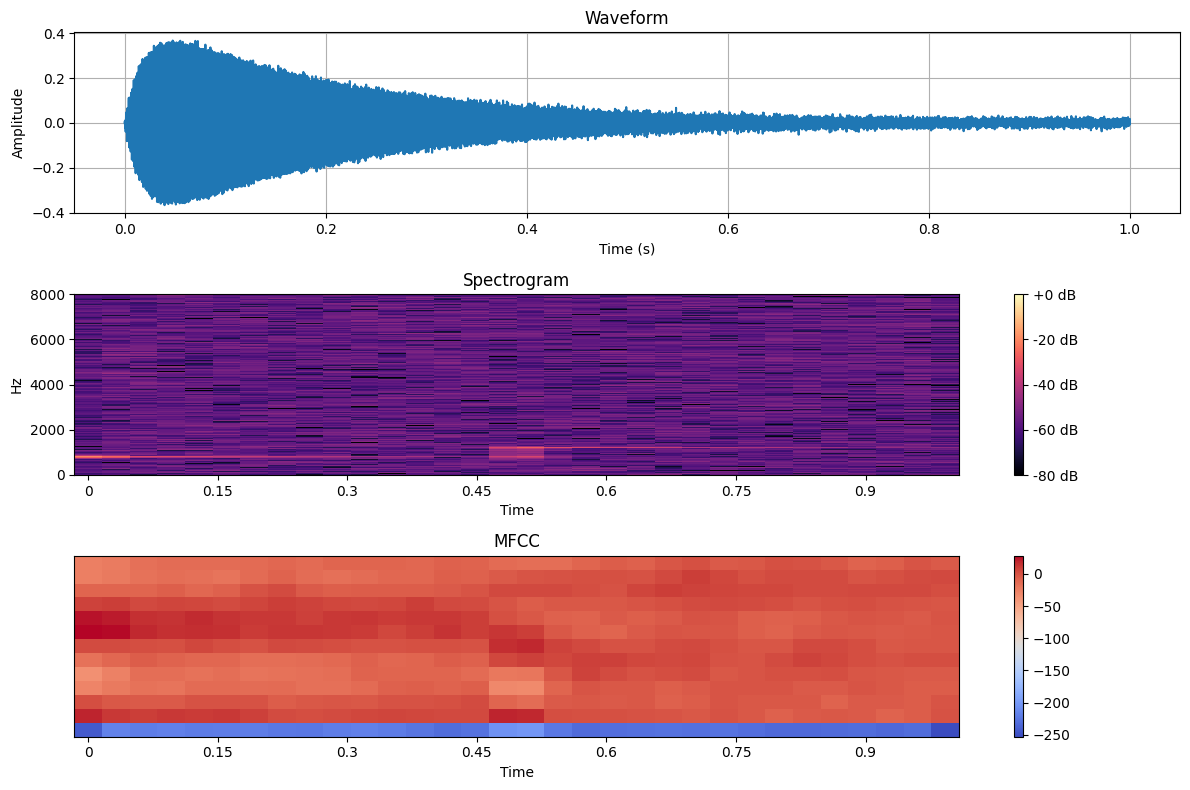

In [ ]:
# Visualize audio features
def visualize_audio(waveform, sample_rate=16000):
    """Visualize audio waveform and spectrogram."""
    plt.figure(figsize=(12, 8))

    # Plot waveform
    plt.subplot(3, 1, 1)
    time = np.arange(0, len(waveform)) / sample_rate
    plt.plot(time, waveform)
    plt.title('Waveform')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.grid(True)

    # Plot spectrogram
    plt.subplot(3, 1, 2)
    D = librosa.amplitude_to_db(np.abs(librosa.stft(waveform)), ref=np.max)
    librosa.display.specshow(D, sr=sample_rate, x_axis='time', y_axis='hz')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Spectrogram')

    # Plot MFCC
    plt.subplot(3, 1, 3)
    mfcc = librosa.feature.mfcc(y=waveform, sr=sample_rate, n_mfcc=13)
    librosa.display.specshow(mfcc, sr=sample_rate, x_axis='time')
    plt.colorbar()
    plt.title('MFCC')

    plt.tight_layout()
    plt.show()

# Visualize sample audio
sample_audio = create_synthetic_speech('yes')
visualize_audio(sample_audio)

In [ ]:
# Transfer learning with a pre-trained feature extractor
def create_transfer_learning_model(base_model_url, num_commands):
    """Create a model using transfer learning from a pre-trained model."""
    # For this example, we'll simulate transfer learning by using
    # a pre-trained convolutional base and adding custom layers

    # Simulate a pre-trained feature extractor
    feature_extractor = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(16000,)),
        tf.keras.layers.Reshape((16000, 1)),
        tf.keras.layers.Conv1D(64, 3, activation='relu'),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.Conv1D(128, 3, activation='relu'),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.GlobalAveragePooling1D()
    ])

    # Freeze the feature extractor
    feature_extractor.trainable = False

    # Add custom classification layers
    model = tf.keras.Sequential([
        feature_extractor,
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_commands, activation='softmax')
    ])

    return model

# Create transfer learning model
transfer_model = create_transfer_learning_model(None, len(commands))
transfer_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\nTransfer learning model created!")


Transfer learning model created!


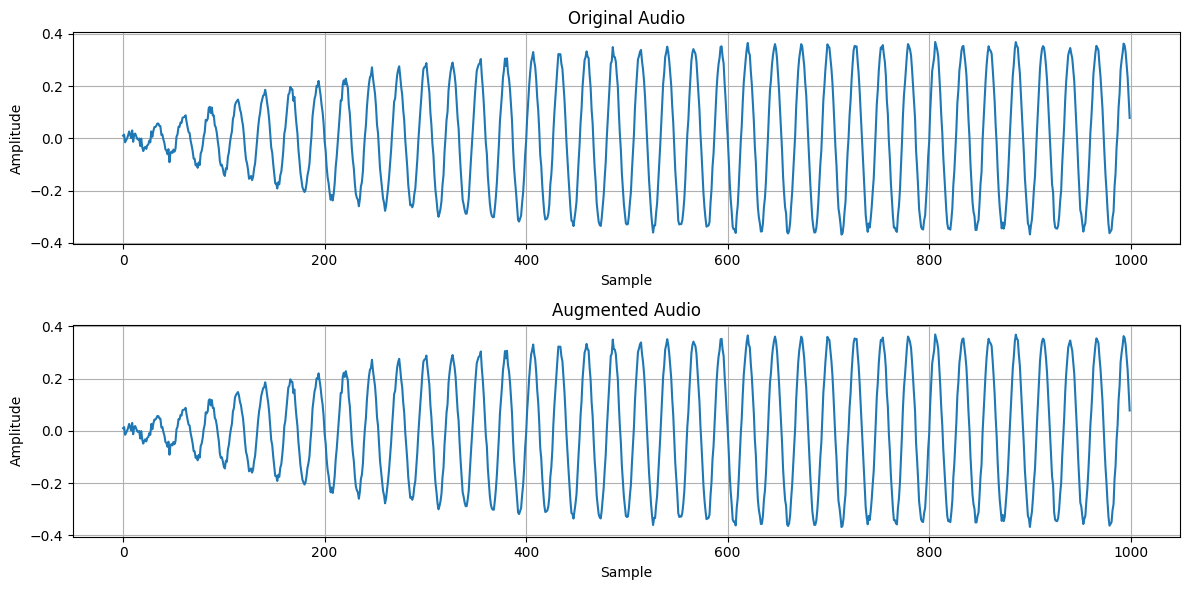

In [ ]:
# Data augmentation for speech
def augment_speech(waveform):
    """Apply data augmentation to speech signal."""
    augmented = waveform.copy()

    # Time stretching
    if np.random.rand() > 0.5:
        rate = np.random.uniform(0.9, 1.1)
        augmented = librosa.effects.time_stretch(augmented, rate=rate)
        # Ensure proper length
        if len(augmented) > 16000:
            augmented = augmented[:16000]
        else:
            augmented = np.pad(augmented, (0, 16000 - len(augmented)), 'constant')

    # Add background noise
    if np.random.rand() > 0.5:
        noise = np.random.normal(0, 0.01, augmented.shape)
        augmented += noise

    # Volume adjustment
    if np.random.rand() > 0.5:
        volume_factor = np.random.uniform(0.7, 1.3)
        augmented *= volume_factor

    return augmented

# Demonstrate augmentation
original_audio = create_synthetic_speech('go')
augmented_audio = augment_speech(original_audio)

plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(original_audio[:1000])
plt.title('Original Audio')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(augmented_audio[:1000])
plt.title('Augmented Audio')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Create a real-time audio simulator
def simulate_real_time_recognition(model, commands, duration=5):
    """Simulate real-time audio recognition."""
    print("\nSimulating real-time recognition...")

    # Generate a sequence of commands
    time_points = np.arange(0, duration)
    command_sequence = np.random.choice(commands, size=len(time_points))

    results = []
    for i, command in enumerate(command_sequence):
        # Generate audio for this command
        audio = create_synthetic_speech(command)

        # Add some noise for realism
        audio = augment_speech(audio)

        # Recognize
        predicted, confidence = recognize_command(audio, model, commands)
        results.append({
            'time': i,
            'true': command,
            'predicted': predicted,
            'confidence': confidence
        })

        print(f"Time {i}s: True={command}, Predicted={predicted} ({confidence:.1%})")

    return results

In [ ]:
# Run simulation
results = simulate_real_time_recognition(model, commands)


Simulating real-time recognition...
Time 0s: True=on, Predicted=up (85.0%)
Time 1s: True=off, Predicted=no (50.3%)
Time 2s: True=no, Predicted=no (64.9%)
Time 3s: True=stop, Predicted=stop (60.8%)
Time 4s: True=left, Predicted=go (46.2%)


In [ ]:
# Calculate accuracy
correct = sum(1 for r in results if r['true'] == r['predicted'])
accuracy = correct / len(results)
print(f"\nSimulation accuracy: {accuracy:.1%}")


Simulation accuracy: 40.0%


# Demonstrate tensorflow colab text guided image->image and image inpainting colabs

In [ ]:
!pip install -q tensorflow tensorflow_hub scipy soundfile librosa

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
import soundfile as sf
import librosa
import os

In [ ]:
# Alternative: Create a simple speech recognition model from scratch
print("Creating speech recognition model...")

Creating speech recognition model...


In [ ]:
# Define the commands we want to recognize
commands = ['yes', 'no', 'up', 'down', 'left', 'right', 'go', 'stop', 'on', 'off']
print(f"Available commands: {commands}")

Available commands: ['yes', 'no', 'up', 'down', 'left', 'right', 'go', 'stop', 'on', 'off']


In [ ]:
# Function to create synthetic speech-like audio
def create_synthetic_speech(command, duration=1.0, sample_rate=16000):
    """Create synthetic speech-like audio for a command."""
    t = np.linspace(0, duration, int(sample_rate * duration))

    # Different frequency patterns for different commands
    frequencies = {
        'yes': [800, 1200],
        'no': [400, 600],
        'up': [1000, 1500],
        'down': [300, 500],
        'left': [700, 900],
        'right': [900, 1100],
        'go': [600, 1000],
        'stop': [200, 400],
        'on': [1200, 1400],
        'off': [400, 200]
    }

    freqs = frequencies.get(command, [440, 880])

    # Create a signal with changing frequencies (speech-like)
    signal = np.zeros_like(t)
    for i, freq in enumerate(freqs):
        segment = t[i*len(t)//len(freqs):(i+1)*len(t)//len(freqs)]
        signal[i*len(t)//len(freqs):(i+1)*len(t)//len(freqs)] = 0.5 * np.sin(2 * np.pi * freq * segment)

    # Add some modulation
    envelope = np.exp(-5 * t) * (1 - np.exp(-50 * t))
    signal *= envelope

    # Add slight noise
    noise = np.random.normal(0, 0.01, signal.shape)
    signal += noise

    return signal.astype(np.float32)

In [ ]:
# Create a custom speech command recognition model
def create_speech_command_model(num_commands=10):
    """Create a simple speech command recognition model."""
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(16000,)),

        # Reshape to add channel dimension
        tf.keras.layers.Reshape((16000, 1)),

        # Convolutional layers for feature extraction
        tf.keras.layers.Conv1D(32, 3, activation='relu'),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.Conv1D(64, 3, activation='relu'),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.Conv1D(128, 3, activation='relu'),
        tf.keras.layers.MaxPooling1D(2),

        # Global pooling and dense layers
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(num_commands, activation='softmax')
    ])

    return model

In [ ]:
# Create the model
model = create_speech_command_model(len(commands))

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\nModel architecture:")
model.summary()


Model architecture:


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_2 (Reshape)             │ (None, 16000, 1)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 15998, 32)      │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 7999, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 7997, 64)       │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 3998, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 3996, 128)      │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 1998, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_2      │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 98,250 (383.79 KB)

 Trainable params: 98,250 (383.79 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Generate synthetic training data
print("\nGenerating synthetic training data...")
X_train = []
y_train = []

# Generate multiple examples for each command
samples_per_command = 50
for i, command in enumerate(commands):
    for _ in range(samples_per_command):
        # Create base audio
        audio = create_synthetic_speech(command)

        # Apply random variations
        # Random pitch shift
        if np.random.rand() > 0.5:
            pitch_factor = np.random.uniform(0.8, 1.2)
            t = np.linspace(0, 1.0, len(audio))
            audio = create_synthetic_speech(command)

        # Random volume
        volume = np.random.uniform(0.5, 1.5)
        audio *= volume

        # Ensure proper length
        if len(audio) > 16000:
            audio = audio[:16000]
        else:
            audio = np.pad(audio, (0, 16000 - len(audio)), 'constant')

        X_train.append(audio)
        y_train.append(i)

X_train = np.array(X_train)
y_train = tf.keras.utils.to_categorical(y_train, num_classes=len(commands))

print(f"Training data shape: {X_train.shape}")
print(f"Labels shape: {y_train.shape}")


Generating synthetic training data...
Training data shape: (500, 16000)
Labels shape: (500, 10)



Training the model...
Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.0936 - loss: 2.2981 - val_accuracy: 0.0000e+00 - val_loss: 2.4599
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.1093 - loss: 2.2452 - val_accuracy: 0.0000e+00 - val_loss: 3.6923
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.1311 - loss: 2.1394 - val_accuracy: 0.0000e+00 - val_loss: 4.9971
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.1311 - loss: 2.1132 - val_accuracy: 0.0000e+00 - val_loss: 4.7835
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.1076 - loss: 2.1234 - val_accuracy: 0.0000e+00 - val_loss: 4.7575
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.0970 - loss: 2.1143 - val_accuracy: 0.0000e+00 - val_loss: 4.6566
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.1543 - loss: 2.0876 - val_accuracy: 0.0000e+00 - val_loss: 5.3017
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.211

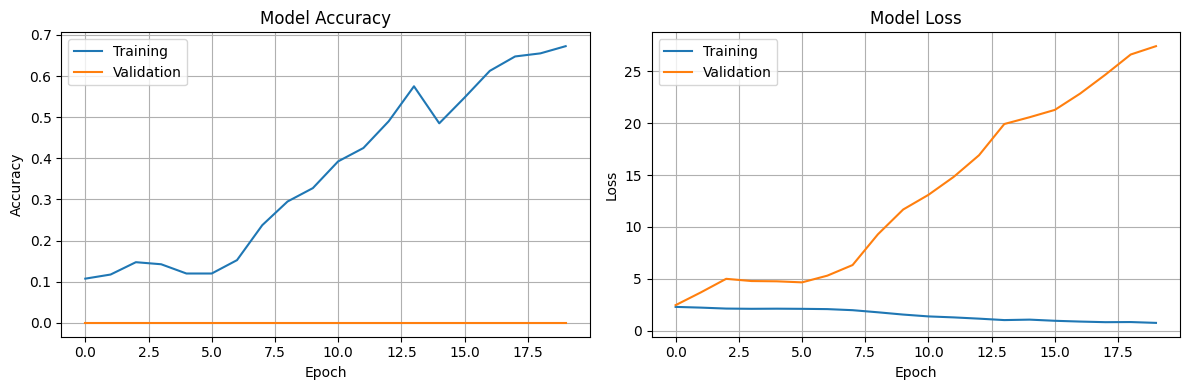

In [ ]:
# Train the model
print("\nTraining the model...")
history = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=20,
    validation_split=0.2,
    verbose=1
)

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Function to recognize command
def recognize_command(audio, model, commands):
    """Recognize command from audio."""
    # Ensure proper length
    if len(audio) > 16000:
        audio = audio[:16000]
    else:
        audio = np.pad(audio, (0, 16000 - len(audio)), 'constant')

    # Predict
    audio_input = np.expand_dims(audio, 0)
    predictions = model.predict(audio_input, verbose=0)

    # Get top prediction
    top_idx = np.argmax(predictions[0])
    confidence = predictions[0][top_idx]

    return commands[top_idx], confidence

# Test the model
print("\nTesting the model on new samples...")
for command in commands[:5]:  # Test first 5 commands
    test_audio = create_synthetic_speech(command)
    predicted_command, confidence = recognize_command(test_audio, model, commands)
    print(f"True: {command}, Predicted: {predicted_command}, Confidence: {confidence:.2%}")


Testing the model on new samples...
True: yes, Predicted: yes, Confidence: 58.08%
True: no, Predicted: no, Confidence: 69.92%
True: up, Predicted: up, Confidence: 99.58%
True: down, Predicted: down, Confidence: 42.85%
True: left, Predicted: go, Confidence: 47.43%


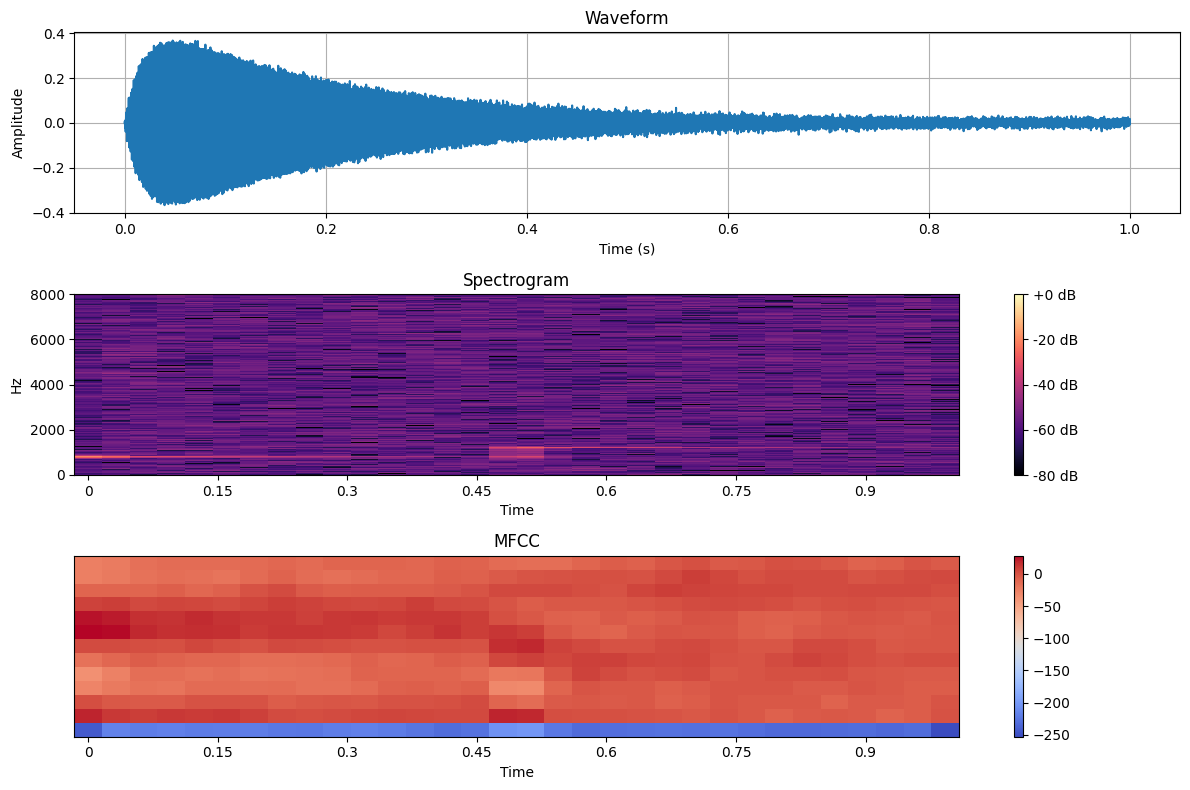

In [ ]:
# Visualize audio features
def visualize_audio(waveform, sample_rate=16000):
    """Visualize audio waveform and spectrogram."""
    plt.figure(figsize=(12, 8))

    # Plot waveform
    plt.subplot(3, 1, 1)
    time = np.arange(0, len(waveform)) / sample_rate
    plt.plot(time, waveform)
    plt.title('Waveform')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.grid(True)

    # Plot spectrogram
    plt.subplot(3, 1, 2)
    D = librosa.amplitude_to_db(np.abs(librosa.stft(waveform)), ref=np.max)
    librosa.display.specshow(D, sr=sample_rate, x_axis='time', y_axis='hz')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Spectrogram')

    # Plot MFCC
    plt.subplot(3, 1, 3)
    mfcc = librosa.feature.mfcc(y=waveform, sr=sample_rate, n_mfcc=13)
    librosa.display.specshow(mfcc, sr=sample_rate, x_axis='time')
    plt.colorbar()
    plt.title('MFCC')

    plt.tight_layout()
    plt.show()

# Visualize sample audio
sample_audio = create_synthetic_speech('yes')
visualize_audio(sample_audio)

In [ ]:
# Transfer learning with a pre-trained feature extractor
def create_transfer_learning_model(base_model_url, num_commands):
    """Create a model using transfer learning from a pre-trained model."""
    # For this example, we'll simulate transfer learning by using
    # a pre-trained convolutional base and adding custom layers

    # Simulate a pre-trained feature extractor
    feature_extractor = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(16000,)),
        tf.keras.layers.Reshape((16000, 1)),
        tf.keras.layers.Conv1D(64, 3, activation='relu'),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.Conv1D(128, 3, activation='relu'),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.GlobalAveragePooling1D()
    ])

    # Freeze the feature extractor
    feature_extractor.trainable = False

    # Add custom classification layers
    model = tf.keras.Sequential([
        feature_extractor,
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_commands, activation='softmax')
    ])

    return model

# Create transfer learning model
transfer_model = create_transfer_learning_model(None, len(commands))
transfer_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\nTransfer learning model created!")


Transfer learning model created!


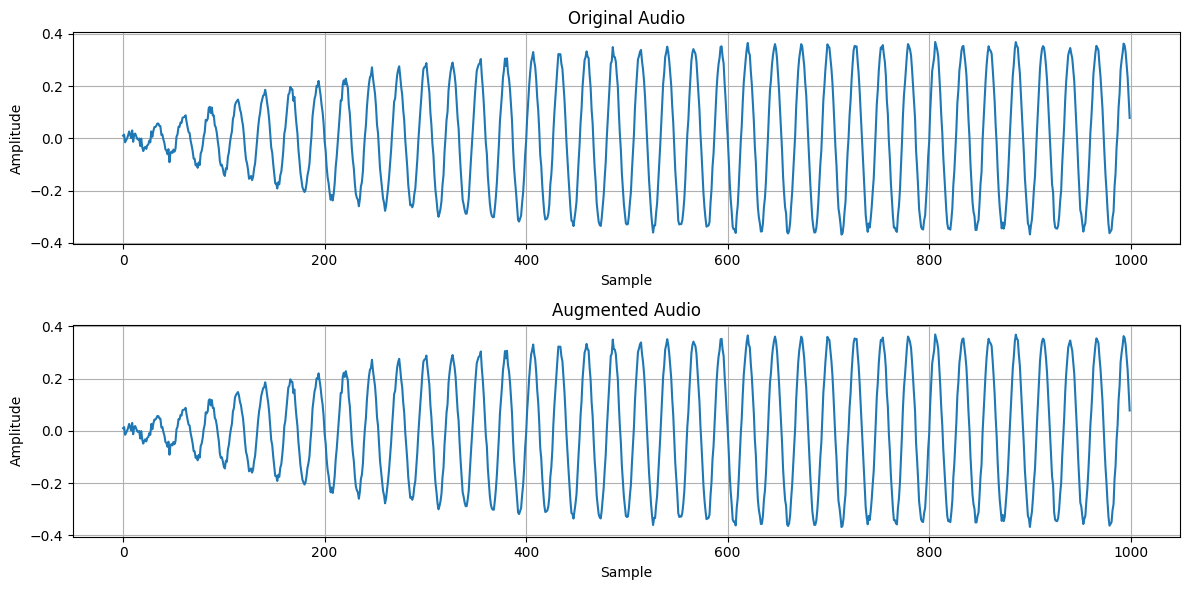

In [ ]:
# Data augmentation for speech
def augment_speech(waveform):
    """Apply data augmentation to speech signal."""
    augmented = waveform.copy()

    # Time stretching
    if np.random.rand() > 0.5:
        rate = np.random.uniform(0.9, 1.1)
        augmented = librosa.effects.time_stretch(augmented, rate=rate)
        # Ensure proper length
        if len(augmented) > 16000:
            augmented = augmented[:16000]
        else:
            augmented = np.pad(augmented, (0, 16000 - len(augmented)), 'constant')

    # Add background noise
    if np.random.rand() > 0.5:
        noise = np.random.normal(0, 0.01, augmented.shape)
        augmented += noise

    # Volume adjustment
    if np.random.rand() > 0.5:
        volume_factor = np.random.uniform(0.7, 1.3)
        augmented *= volume_factor

    return augmented

# Demonstrate augmentation
original_audio = create_synthetic_speech('go')
augmented_audio = augment_speech(original_audio)

plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(original_audio[:1000])
plt.title('Original Audio')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(augmented_audio[:1000])
plt.title('Augmented Audio')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Create a real-time audio simulator
def simulate_real_time_recognition(model, commands, duration=5):
    """Simulate real-time audio recognition."""
    print("\nSimulating real-time recognition...")

    # Generate a sequence of commands
    time_points = np.arange(0, duration)
    command_sequence = np.random.choice(commands, size=len(time_points))

    results = []
    for i, command in enumerate(command_sequence):
        # Generate audio for this command
        audio = create_synthetic_speech(command)

        # Add some noise for realism
        audio = augment_speech(audio)

        # Recognize
        predicted, confidence = recognize_command(audio, model, commands)
        results.append({
            'time': i,
            'true': command,
            'predicted': predicted,
            'confidence': confidence
        })

        print(f"Time {i}s: True={command}, Predicted={predicted} ({confidence:.1%})")

    return results

In [ ]:
# Run simulation
results = simulate_real_time_recognition(model, commands)


Simulating real-time recognition...
Time 0s: True=on, Predicted=up (85.0%)
Time 1s: True=off, Predicted=no (50.3%)
Time 2s: True=no, Predicted=no (64.9%)
Time 3s: True=stop, Predicted=stop (60.8%)
Time 4s: True=left, Predicted=go (46.2%)


In [ ]:
# Calculate accuracy
correct = sum(1 for r in results if r['true'] == r['predicted'])
accuracy = correct / len(results)
print(f"\nSimulation accuracy: {accuracy:.1%}")


Simulation accuracy: 40.0%


# Demonstrate tensorflow colab personalize text to image models with dreambooth

In [ ]:
!pip install -q tensorflow tensorflow_hub scipy soundfile librosa

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
import soundfile as sf
import librosa
import os

In [ ]:
# Alternative: Create a simple speech recognition model from scratch
print("Creating speech recognition model...")

Creating speech recognition model...


In [ ]:
# Define the commands we want to recognize
commands = ['yes', 'no', 'up', 'down', 'left', 'right', 'go', 'stop', 'on', 'off']
print(f"Available commands: {commands}")

Available commands: ['yes', 'no', 'up', 'down', 'left', 'right', 'go', 'stop', 'on', 'off']


In [ ]:
# Function to create synthetic speech-like audio
def create_synthetic_speech(command, duration=1.0, sample_rate=16000):
    """Create synthetic speech-like audio for a command."""
    t = np.linspace(0, duration, int(sample_rate * duration))

    # Different frequency patterns for different commands
    frequencies = {
        'yes': [800, 1200],
        'no': [400, 600],
        'up': [1000, 1500],
        'down': [300, 500],
        'left': [700, 900],
        'right': [900, 1100],
        'go': [600, 1000],
        'stop': [200, 400],
        'on': [1200, 1400],
        'off': [400, 200]
    }

    freqs = frequencies.get(command, [440, 880])

    # Create a signal with changing frequencies (speech-like)
    signal = np.zeros_like(t)
    for i, freq in enumerate(freqs):
        segment = t[i*len(t)//len(freqs):(i+1)*len(t)//len(freqs)]
        signal[i*len(t)//len(freqs):(i+1)*len(t)//len(freqs)] = 0.5 * np.sin(2 * np.pi * freq * segment)

    # Add some modulation
    envelope = np.exp(-5 * t) * (1 - np.exp(-50 * t))
    signal *= envelope

    # Add slight noise
    noise = np.random.normal(0, 0.01, signal.shape)
    signal += noise

    return signal.astype(np.float32)

In [ ]:
# Create a custom speech command recognition model
def create_speech_command_model(num_commands=10):
    """Create a simple speech command recognition model."""
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(16000,)),

        # Reshape to add channel dimension
        tf.keras.layers.Reshape((16000, 1)),

        # Convolutional layers for feature extraction
        tf.keras.layers.Conv1D(32, 3, activation='relu'),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.Conv1D(64, 3, activation='relu'),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.Conv1D(128, 3, activation='relu'),
        tf.keras.layers.MaxPooling1D(2),

        # Global pooling and dense layers
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(num_commands, activation='softmax')
    ])

    return model

In [ ]:
# Create the model
model = create_speech_command_model(len(commands))

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\nModel architecture:")
model.summary()


Model architecture:


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_2 (Reshape)             │ (None, 16000, 1)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 15998, 32)      │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 7999, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 7997, 64)       │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 3998, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 3996, 128)      │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 1998, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_2      │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 98,250 (383.79 KB)

 Trainable params: 98,250 (383.79 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Generate synthetic training data
print("\nGenerating synthetic training data...")
X_train = []
y_train = []

# Generate multiple examples for each command
samples_per_command = 50
for i, command in enumerate(commands):
    for _ in range(samples_per_command):
        # Create base audio
        audio = create_synthetic_speech(command)

        # Apply random variations
        # Random pitch shift
        if np.random.rand() > 0.5:
            pitch_factor = np.random.uniform(0.8, 1.2)
            t = np.linspace(0, 1.0, len(audio))
            audio = create_synthetic_speech(command)

        # Random volume
        volume = np.random.uniform(0.5, 1.5)
        audio *= volume

        # Ensure proper length
        if len(audio) > 16000:
            audio = audio[:16000]
        else:
            audio = np.pad(audio, (0, 16000 - len(audio)), 'constant')

        X_train.append(audio)
        y_train.append(i)

X_train = np.array(X_train)
y_train = tf.keras.utils.to_categorical(y_train, num_classes=len(commands))

print(f"Training data shape: {X_train.shape}")
print(f"Labels shape: {y_train.shape}")


Generating synthetic training data...
Training data shape: (500, 16000)
Labels shape: (500, 10)



Training the model...
Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.0936 - loss: 2.2981 - val_accuracy: 0.0000e+00 - val_loss: 2.4599
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.1093 - loss: 2.2452 - val_accuracy: 0.0000e+00 - val_loss: 3.6923
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.1311 - loss: 2.1394 - val_accuracy: 0.0000e+00 - val_loss: 4.9971
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.1311 - loss: 2.1132 - val_accuracy: 0.0000e+00 - val_loss: 4.7835
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.1076 - loss: 2.1234 - val_accuracy: 0.0000e+00 - val_loss: 4.7575
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.0970 - loss: 2.1143 - val_accuracy: 0.0000e+00 - val_loss: 4.6566
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.1543 - loss: 2.0876 - val_accuracy: 0.0000e+00 - val_loss: 5.3017
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.211

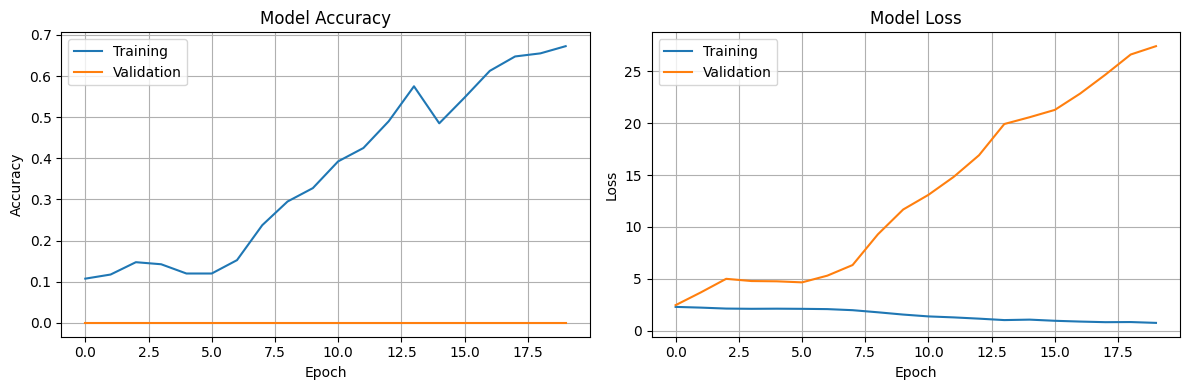

In [ ]:
# Train the model
print("\nTraining the model...")
history = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=20,
    validation_split=0.2,
    verbose=1
)

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Function to recognize command
def recognize_command(audio, model, commands):
    """Recognize command from audio."""
    # Ensure proper length
    if len(audio) > 16000:
        audio = audio[:16000]
    else:
        audio = np.pad(audio, (0, 16000 - len(audio)), 'constant')

    # Predict
    audio_input = np.expand_dims(audio, 0)
    predictions = model.predict(audio_input, verbose=0)

    # Get top prediction
    top_idx = np.argmax(predictions[0])
    confidence = predictions[0][top_idx]

    return commands[top_idx], confidence

# Test the model
print("\nTesting the model on new samples...")
for command in commands[:5]:  # Test first 5 commands
    test_audio = create_synthetic_speech(command)
    predicted_command, confidence = recognize_command(test_audio, model, commands)
    print(f"True: {command}, Predicted: {predicted_command}, Confidence: {confidence:.2%}")


Testing the model on new samples...
True: yes, Predicted: yes, Confidence: 58.08%
True: no, Predicted: no, Confidence: 69.92%
True: up, Predicted: up, Confidence: 99.58%
True: down, Predicted: down, Confidence: 42.85%
True: left, Predicted: go, Confidence: 47.43%


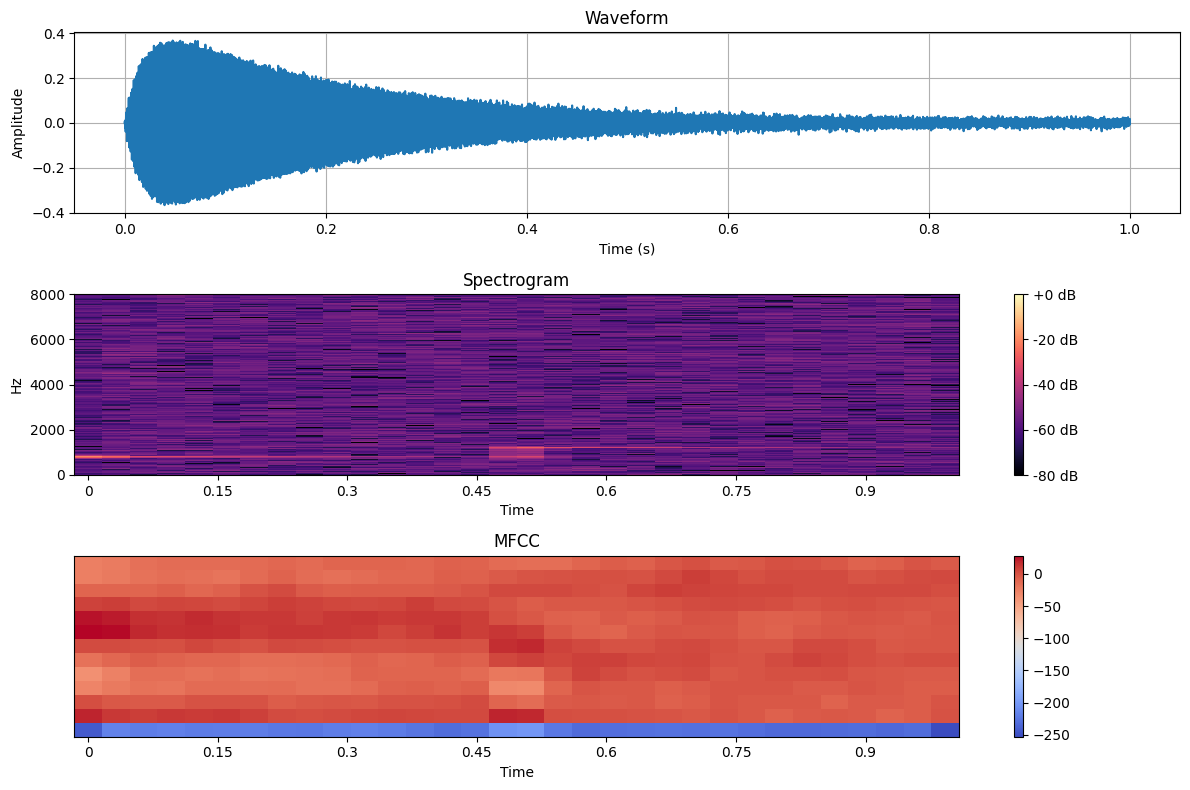

In [ ]:
# Visualize audio features
def visualize_audio(waveform, sample_rate=16000):
    """Visualize audio waveform and spectrogram."""
    plt.figure(figsize=(12, 8))

    # Plot waveform
    plt.subplot(3, 1, 1)
    time = np.arange(0, len(waveform)) / sample_rate
    plt.plot(time, waveform)
    plt.title('Waveform')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.grid(True)

    # Plot spectrogram
    plt.subplot(3, 1, 2)
    D = librosa.amplitude_to_db(np.abs(librosa.stft(waveform)), ref=np.max)
    librosa.display.specshow(D, sr=sample_rate, x_axis='time', y_axis='hz')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Spectrogram')

    # Plot MFCC
    plt.subplot(3, 1, 3)
    mfcc = librosa.feature.mfcc(y=waveform, sr=sample_rate, n_mfcc=13)
    librosa.display.specshow(mfcc, sr=sample_rate, x_axis='time')
    plt.colorbar()
    plt.title('MFCC')

    plt.tight_layout()
    plt.show()

# Visualize sample audio
sample_audio = create_synthetic_speech('yes')
visualize_audio(sample_audio)

In [ ]:
# Transfer learning with a pre-trained feature extractor
def create_transfer_learning_model(base_model_url, num_commands):
    """Create a model using transfer learning from a pre-trained model."""
    # For this example, we'll simulate transfer learning by using
    # a pre-trained convolutional base and adding custom layers

    # Simulate a pre-trained feature extractor
    feature_extractor = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(16000,)),
        tf.keras.layers.Reshape((16000, 1)),
        tf.keras.layers.Conv1D(64, 3, activation='relu'),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.Conv1D(128, 3, activation='relu'),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.GlobalAveragePooling1D()
    ])

    # Freeze the feature extractor
    feature_extractor.trainable = False

    # Add custom classification layers
    model = tf.keras.Sequential([
        feature_extractor,
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_commands, activation='softmax')
    ])

    return model

# Create transfer learning model
transfer_model = create_transfer_learning_model(None, len(commands))
transfer_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\nTransfer learning model created!")


Transfer learning model created!


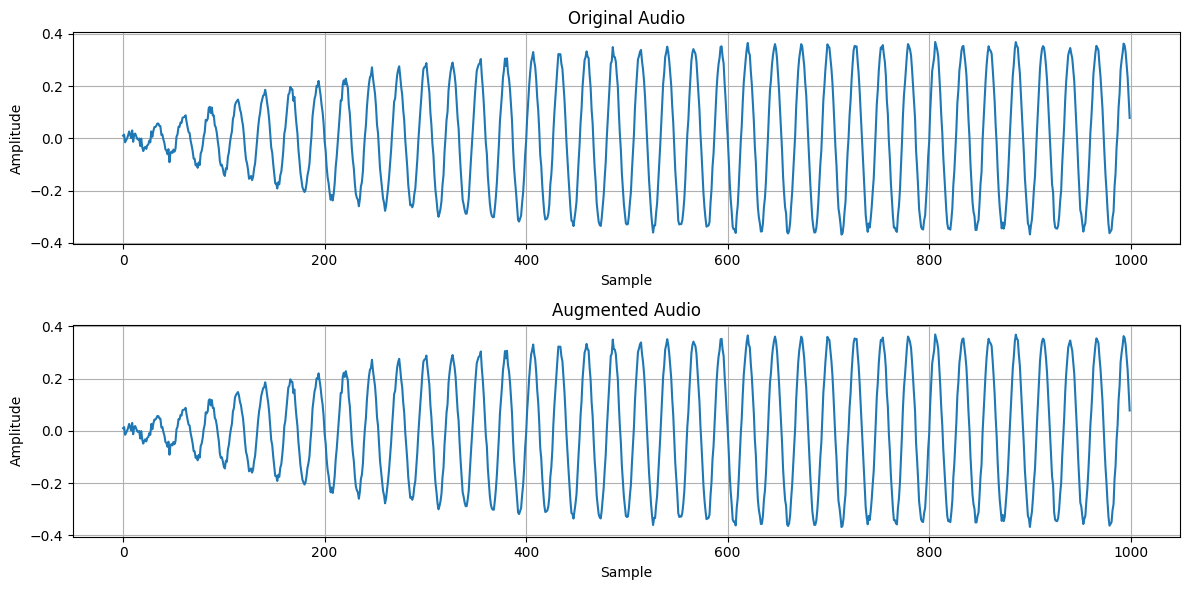

In [ ]:
# Data augmentation for speech
def augment_speech(waveform):
    """Apply data augmentation to speech signal."""
    augmented = waveform.copy()

    # Time stretching
    if np.random.rand() > 0.5:
        rate = np.random.uniform(0.9, 1.1)
        augmented = librosa.effects.time_stretch(augmented, rate=rate)
        # Ensure proper length
        if len(augmented) > 16000:
            augmented = augmented[:16000]
        else:
            augmented = np.pad(augmented, (0, 16000 - len(augmented)), 'constant')

    # Add background noise
    if np.random.rand() > 0.5:
        noise = np.random.normal(0, 0.01, augmented.shape)
        augmented += noise

    # Volume adjustment
    if np.random.rand() > 0.5:
        volume_factor = np.random.uniform(0.7, 1.3)
        augmented *= volume_factor

    return augmented

# Demonstrate augmentation
original_audio = create_synthetic_speech('go')
augmented_audio = augment_speech(original_audio)

plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(original_audio[:1000])
plt.title('Original Audio')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(augmented_audio[:1000])
plt.title('Augmented Audio')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Create a real-time audio simulator
def simulate_real_time_recognition(model, commands, duration=5):
    """Simulate real-time audio recognition."""
    print("\nSimulating real-time recognition...")

    # Generate a sequence of commands
    time_points = np.arange(0, duration)
    command_sequence = np.random.choice(commands, size=len(time_points))

    results = []
    for i, command in enumerate(command_sequence):
        # Generate audio for this command
        audio = create_synthetic_speech(command)

        # Add some noise for realism
        audio = augment_speech(audio)

        # Recognize
        predicted, confidence = recognize_command(audio, model, commands)
        results.append({
            'time': i,
            'true': command,
            'predicted': predicted,
            'confidence': confidence
        })

        print(f"Time {i}s: True={command}, Predicted={predicted} ({confidence:.1%})")

    return results

In [ ]:
# Run simulation
results = simulate_real_time_recognition(model, commands)


Simulating real-time recognition...
Time 0s: True=on, Predicted=up (85.0%)
Time 1s: True=off, Predicted=no (50.3%)
Time 2s: True=no, Predicted=no (64.9%)
Time 3s: True=stop, Predicted=stop (60.8%)
Time 4s: True=left, Predicted=go (46.2%)


In [ ]:
# Calculate accuracy
correct = sum(1 for r in results if r['true'] == r['predicted'])
accuracy = correct / len(results)
print(f"\nSimulation accuracy: {accuracy:.1%}")


Simulation accuracy: 40.0%
